<html>
<body>
<p style="font-size:20px;color:blue;">EXERCISE 2</p>
<p style="font-size:15px;color:#64B5F6;">Step 1</p>
</body>
</html>


The code that follows stores the ratings, users and businesses that satisfy the requirements.

In [ ]:
import numpy as np
import json
import ijson # library used for reading the file one line at a time, because we can't load the whole file in memory


f1 = open('yelp_academic_dataset_business.json', encoding = "utf8")

torontoBusinesses = {} # mapping each toronto business id to its review count
torontoID = [] # a list of all the toronto businesses id's

for line in f1.readlines():
    dictionary = json.loads(line)
    if((dictionary['city'] == 'Toronto') and (dictionary['review_count'] >= 15)): # requirements
        torontoBusinesses[dictionary["business_id"]] = dictionary["review_count"]
        torontoID.append(dictionary["business_id"])

torontoID = np.array(torontoID) 

users = [] # a list of all user id's
users_with_reviews = [] # stores the user id and a dictionary which stores the businesses he has rated and the ratings themselves

with open('yelp_academic_dataset_review.json', 'r', encoding = "UTF-8") as f:
    parser = ijson.parse(f, multiple_values = True)
    business_id = ""
    user_id = ""
    user_already_encountered = False
    businessInToronto = False # only if the business is in Toronto do we care about the rating
    
    for prefix, event, value in parser:
        if(prefix == "user_id"):
            user_id = value    
        elif(prefix == "business_id"):
            business_id = value

            if(business_id in torontoID):
                 businessInToronto = True
            else:
                businessInToronto = False
        elif(prefix == "stars"):
            if(businessInToronto == True):
                if(user_id in users):
                    user_already_encountered = True
                else:
                    user_already_encountered = False
                    users.append(user_id)

                if(user_already_encountered == True):
                    for element in users_with_reviews:
                        if(element["user_id"] == user_id):
                            element["businesses"][business_id] = value
                            break
                else:
                    user_with_reviews = {"user_id": user_id, "businesses": {business_id: value}}
                    users_with_reviews.append(user_with_reviews)
        
          
print("Writing the data..")  

with open('my_pruned_data.csv', 'w') as f1:
    for element in users_with_reviews:
        if(len(element["businesses"]) >= 15): # which translates to "if the user has rated at least 15 businesses"
            for key in element["businesses"]:
                if(torontoBusinesses[key] >= 15): # which translates to "if the business has at least 15 ratings"
                    line = element["user_id"] + "," + key + ", " + str(element["businesses"][key]) + "\n"
                    f1.write(line)
        else:
            for key in element["businesses"]: # if the user hasn't rated at least 15 businesses, he won't be added to the set,
                torontoBusinesses[key] -= 1 # which means we need to remove his rating from the count of each business he has rated

<html>
<body>
<p style="font-size:15px;color:#64B5F6;">Step 2</p>
</body>
</html>

My my_pruned_data.csv file was not the same size as the one provided by the instructor, so I decided to use the file the instructor provided.

In [1]:
import numpy as np
from scipy import sparse
import csv
import random

user_indices = [] # the indices of each user id. Each list position refers to the index of the user in the corresponding line of the file
business_indices = [] # the indices of each business id. Each list position refers to the index of the business in the corresponding line of the file
ratings = [] # the ratings of each line
user_map = {} # a dictionary which matches each user id with its index
business_map = {} # a dictionary which matches each business id with its index

business_rated_by = {} # a dictionary with keys being business indices and values being the list of indices of the users that rated the business
user_has_reviewed = {} # a dictionary with keys being user indices and values being the list of indices of the business that the user has reviewed

with open('pruned_data.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    user_index = -1
    business_index = -1
    previously_parsed_user = '' # id
    previously_parsed_business = '' # id
    businessAlreadyRecorded = False # business id's don't appear in order, which means we need to remember if the business has already been indexed

    for line in csv_reader:
        if(line[0] != previously_parsed_user): # if the next user id is different, then the previous id won't appear again due to the file structure
            user_index += 1
            previously_parsed_user = line[0]
            user_has_reviewed[user_index] = []
        
        user_indices.append(user_index)   
        user_map[line[0]] = user_index    

        for business in business_map.keys(): # check if we have already recorder the business id of this line
            if(line[1] == business):
                businessAlreadyRecorded = True
                break

        if(not businessAlreadyRecorded): # then we need to assign a new index and record it
            business_index += 1
            business_map[line[1]] = business_index
            business_rated_by[business_index] = []
            
        business_rated_by[business_map[line[1]]].append(user_index)
        user_has_reviewed[user_index].append(business_map[line[1]])

        business_indices.append(business_map[line[1]]) 
        businessAlreadyRecorded = False # back to false for the next line iteration

        ratings.append(float(line[2]))


user_indicesNP = np.array(user_indices)
business_indicesNP = np.array(business_indices)
ratingsNP = np.array(ratings)



Creating a sparse matrix and deleting 5% of the ratings from it:

In [2]:
R = sparse.csr_matrix((ratingsNP, (user_indicesNP, business_indicesNP)))


numberOfRatingsToBeRemoved = int(0.05 * len(ratings))

# we need to keep the indices of the business/user ratings that we removed
removedUserPositions = []
removedBusinessPositions = []
users_that_reviewed_the_same_business = []
removedRatings = np.zeros(numberOfRatingsToBeRemoved)


for i in range(numberOfRatingsToBeRemoved):
    pos = random.randint(0, len(ratings) - 1)

    while(ratings[pos] is None): # we need to check that the random rating hasn't already been removed
        pos = random.randint(0, len(ratings) - 1)

    removedRatings[i] = ratings[pos]
    removedUserPositions.append(user_indices[pos])
    removedBusinessPositions.append(business_indices[pos])
    ratings[pos] = None
    
    
for i in range(numberOfRatingsToBeRemoved): # actual removal of the ratings from the sparse matrix
    R[removedUserPositions[i], removedBusinessPositions[i]] = 0
        

<html>
<body>
<p style="font-size:15px;color:#64B5F6;">Step 3</p>
<p>I declare a UCF function which is parameterised by a integer k, because later on we will need to run the function in repeatedly for different number of k similar users, in order to record RMSE values.</p>
</body>
</html>

In [3]:
from sklearn import metrics

#User-Based Collaborative Filtering (UCF)

def UCF(k):
    similarity_matrix = metrics.pairwise.cosine_similarity(R, Y=None, dense_output=True)
    u_pos = -1 # index that will be used to get each user index from the removedUserPositions list

    predicted_missing_ratings = []
    R_Array = R.toarray()

    for b in removedBusinessPositions:

        u_pos += 1
        u = removedUserPositions[u_pos]

        users_that_reviewed = business_rated_by[b] # we need all the users that reviewed this business for similarity computations

        if u in users_that_reviewed:
            users_that_reviewed.remove(u) # the same user shouldn't appear twice


        user_similarities = []
        user_dict = {}

        for user in users_that_reviewed: # get the similarities with each user that reviewed the same business
            similarity = similarity_matrix[user, u]
            user_similarities.append(similarity)
            user_dict[similarity] = user

        user_similarities = np.array(user_similarities)
        k_most_similar_similarities = []
        
        if(len(user_similarities) > k):
            k_most_similar_similarities = np.partition(user_similarities, -k)[-k:]
        else: # in this case we have less than k users that reviewed the same business, so we keep all the users
            k_most_similar_similarities = user_similarities
        k_most_similar_users = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities: # store the k most similar users
            k_most_similar_users.append(user_dict[similarity])

        for user in k_most_similar_users: # store the ratings of those users
            k_most_similar_ratings.append(R_Array[user,b])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

predictions = UCF(10) # testing the method and printing its results

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] )

Removed rating:  3.0  Prediction:  3.108073114005036
Removed rating:  4.0  Prediction:  3.2184170514767634
Removed rating:  5.0  Prediction:  3.297840756231448
Removed rating:  3.0  Prediction:  2.8975006076349215
Removed rating:  2.0  Prediction:  4.139228378158751
Removed rating:  3.0  Prediction:  2.934677775915282
Removed rating:  4.0  Prediction:  3.332580845478891
Removed rating:  4.0  Prediction:  3.2184116109730456
Removed rating:  4.0  Prediction:  2.8178854892042136
Removed rating:  3.0  Prediction:  3.571792316573434
Removed rating:  4.0  Prediction:  3.261013018728248
Removed rating:  5.0  Prediction:  3.588719498404484
Removed rating:  4.0  Prediction:  3.750260716068179
Removed rating:  3.0  Prediction:  2.9961640601397854
Removed rating:  4.0  Prediction:  3.9297541774967177
Removed rating:  1.0  Prediction:  2.7905965912001354
Removed rating:  3.0  Prediction:  4.1653841270092125
Removed rating:  4.0  Prediction:  3.7501957003012842
Removed rating:  5.0  Prediction:  3.

Removed rating:  1.0  Prediction:  3.088592391951708
Removed rating:  5.0  Prediction:  3.694380848878003
Removed rating:  5.0  Prediction:  3.50266256267931
Removed rating:  2.0  Prediction:  2.9312904098755923
Removed rating:  1.0  Prediction:  3.9168327715543834
Removed rating:  2.0  Prediction:  3.5815017434553456
Removed rating:  5.0  Prediction:  3.7215952963363526
Removed rating:  4.0  Prediction:  3.8238477264701554
Removed rating:  4.0  Prediction:  2.5633610168764753
Removed rating:  4.0  Prediction:  3.276439026289355
Removed rating:  1.0  Prediction:  3.581743711979029
Removed rating:  5.0  Prediction:  4.023114571999826
Removed rating:  4.0  Prediction:  4.015269590628512
Removed rating:  4.0  Prediction:  3.6487370627500337
Removed rating:  3.0  Prediction:  3.42565461987896
Removed rating:  4.0  Prediction:  4.261418065722197
Removed rating:  3.0  Prediction:  3.0900101709498733
Removed rating:  5.0  Prediction:  3.8145938667748367
Removed rating:  3.0  Prediction:  3.52

Removed rating:  3.0  Prediction:  4.092707154848791
Removed rating:  5.0  Prediction:  3.6786537635160412
Removed rating:  4.0  Prediction:  4.118554100624517
Removed rating:  2.0  Prediction:  2.8164446730277235
Removed rating:  5.0  Prediction:  4.402655347534238
Removed rating:  4.0  Prediction:  3.8880813731423425
Removed rating:  4.0  Prediction:  3.1839044672970473
Removed rating:  2.0  Prediction:  3.2233404031329487
Removed rating:  3.0  Prediction:  3.1206841747962106
Removed rating:  1.0  Prediction:  3.000565250313041
Removed rating:  4.0  Prediction:  3.2119399308916745
Removed rating:  3.0  Prediction:  3.4322851158682925
Removed rating:  3.0  Prediction:  3.150546174576746
Removed rating:  5.0  Prediction:  4.122201263490941
Removed rating:  4.0  Prediction:  3.813799728681851
Removed rating:  5.0  Prediction:  2.8754142778705805
Removed rating:  4.0  Prediction:  2.6521094527293942
Removed rating:  5.0  Prediction:  3.4232754400551335
Removed rating:  3.0  Prediction:  

Removed rating:  4.0  Prediction:  2.689695472477092
Removed rating:  5.0  Prediction:  4.7804668552731275
Removed rating:  4.0  Prediction:  4.02905942308155
Removed rating:  4.0  Prediction:  3.6177745814501305
Removed rating:  5.0  Prediction:  3.276573170523867
Removed rating:  5.0  Prediction:  3.864423588332182
Removed rating:  3.0  Prediction:  3.1142131020454666
Removed rating:  5.0  Prediction:  4.39476931324658
Removed rating:  1.0  Prediction:  3.4325988391685787
Removed rating:  4.0  Prediction:  4.121439306419364
Removed rating:  4.0  Prediction:  3.8747405933419725
Removed rating:  4.0  Prediction:  3.753400870135315
Removed rating:  4.0  Prediction:  3.818096659134
Removed rating:  4.0  Prediction:  3.330100063621201
Removed rating:  5.0  Prediction:  3.380438275716005
Removed rating:  5.0  Prediction:  3.104064127578887
Removed rating:  4.0  Prediction:  4.102661123847289
Removed rating:  2.0  Prediction:  3.1872315824299973
Removed rating:  5.0  Prediction:  4.64737601

Removed rating:  3.0  Prediction:  2.203312175403095
Removed rating:  4.0  Prediction:  4.147670685171807
Removed rating:  3.0  Prediction:  3.9173869938557093
Removed rating:  1.0  Prediction:  3.857837395132128
Removed rating:  4.0  Prediction:  3.020202254216514
Removed rating:  2.0  Prediction:  3.972898586480504
Removed rating:  5.0  Prediction:  3.51275400443148
Removed rating:  5.0  Prediction:  3.8936102316778327
Removed rating:  4.0  Prediction:  3.2804849080471867
Removed rating:  3.0  Prediction:  4.081604398900841
Removed rating:  4.0  Prediction:  2.9978714115679135
Removed rating:  3.0  Prediction:  2.7625289774583597
Removed rating:  4.0  Prediction:  3.1468062651635353
Removed rating:  1.0  Prediction:  3.4472566648992706
Removed rating:  3.0  Prediction:  3.321910980759127
Removed rating:  4.0  Prediction:  4.4948693117161875
Removed rating:  5.0  Prediction:  4.612895372044923
Removed rating:  4.0  Prediction:  4.306322029106455
Removed rating:  4.0  Prediction:  3.63

Removed rating:  3.0  Prediction:  2.6506130596572213
Removed rating:  5.0  Prediction:  2.788106428194752
Removed rating:  5.0  Prediction:  3.1106510790380084
Removed rating:  4.0  Prediction:  3.1966168217753888
Removed rating:  3.0  Prediction:  3.795248514265636
Removed rating:  5.0  Prediction:  2.1874011951946923
Removed rating:  5.0  Prediction:  4.205926974769033
Removed rating:  4.0  Prediction:  3.3760089962835313
Removed rating:  4.0  Prediction:  3.5212747073072346
Removed rating:  2.0  Prediction:  2.3525803981758058
Removed rating:  4.0  Prediction:  2.922564154853509
Removed rating:  2.0  Prediction:  4.01471568825512
Removed rating:  1.0  Prediction:  2.684903760712725
Removed rating:  5.0  Prediction:  3.6387949502180277
Removed rating:  3.0  Prediction:  3.291566114621981
Removed rating:  5.0  Prediction:  3.674485427984617
Removed rating:  3.0  Prediction:  3.9645192109071803
Removed rating:  3.0  Prediction:  3.613164992270609
Removed rating:  1.0  Prediction:  3.5

Removed rating:  4.0  Prediction:  4.042711419050643
Removed rating:  5.0  Prediction:  3.439865151595526
Removed rating:  4.0  Prediction:  4.092621885459194
Removed rating:  4.0  Prediction:  3.6607561768847536
Removed rating:  3.0  Prediction:  3.848581938680243
Removed rating:  2.0  Prediction:  3.4734419060007236
Removed rating:  2.0  Prediction:  3.8786748542779996
Removed rating:  1.0  Prediction:  3.6138085814026004
Removed rating:  3.0  Prediction:  3.1503458412362337
Removed rating:  5.0  Prediction:  4.2893250755891215
Removed rating:  5.0  Prediction:  3.700769775581268
Removed rating:  4.0  Prediction:  3.9395164876217184
Removed rating:  3.0  Prediction:  3.6701097815610555
Removed rating:  1.0  Prediction:  3.693560473053144
Removed rating:  4.0  Prediction:  3.6599861706651344
Removed rating:  3.0  Prediction:  3.7122277834115263
Removed rating:  5.0  Prediction:  2.8255982514640317
Removed rating:  4.0  Prediction:  3.8080478219559546
Removed rating:  2.0  Prediction: 

Removed rating:  4.0  Prediction:  4.5360292882151905
Removed rating:  4.0  Prediction:  4.206467479874883
Removed rating:  5.0  Prediction:  2.7524588524020963
Removed rating:  4.0  Prediction:  3.6201848582066436
Removed rating:  4.0  Prediction:  3.0734339943965683
Removed rating:  4.0  Prediction:  3.3347307613375077
Removed rating:  5.0  Prediction:  3.6762537086111338
Removed rating:  5.0  Prediction:  3.9878374543618036
Removed rating:  1.0  Prediction:  2.0475227107116174
Removed rating:  4.0  Prediction:  3.4133135183276453
Removed rating:  5.0  Prediction:  4.562781560567451
Removed rating:  5.0  Prediction:  3.700488247379282
Removed rating:  4.0  Prediction:  3.536068255963793
Removed rating:  4.0  Prediction:  4.347084458742038
Removed rating:  4.0  Prediction:  2.5799837481911494
Removed rating:  1.0  Prediction:  3.594017182381005
Removed rating:  4.0  Prediction:  3.3791098815185663
Removed rating:  5.0  Prediction:  2.8703742999633555
Removed rating:  4.0  Prediction: 

Removed rating:  3.0  Prediction:  3.4005577865892187
Removed rating:  2.0  Prediction:  3.429135221813212
Removed rating:  4.0  Prediction:  4.176888552712073
Removed rating:  5.0  Prediction:  4.1094473603987565
Removed rating:  3.0  Prediction:  3.5108087476146985
Removed rating:  2.0  Prediction:  3.4655921473731195
Removed rating:  1.0  Prediction:  3.290947625391734
Removed rating:  4.0  Prediction:  3.7571133141752555
Removed rating:  5.0  Prediction:  4.488679564372622
Removed rating:  3.0  Prediction:  2.9743591671042098
Removed rating:  3.0  Prediction:  2.3071790652027167
Removed rating:  4.0  Prediction:  3.016992089691697
Removed rating:  1.0  Prediction:  2.146766778019006
Removed rating:  5.0  Prediction:  3.917484114013414
Removed rating:  5.0  Prediction:  3.748395570115299
Removed rating:  4.0  Prediction:  4.09285463984842
Removed rating:  4.0  Prediction:  2.0173447058034615
Removed rating:  4.0  Prediction:  3.498045263346928
Removed rating:  3.0  Prediction:  3.00

Removed rating:  5.0  Prediction:  3.0738864425458208
Removed rating:  2.0  Prediction:  3.722910908991423
Removed rating:  5.0  Prediction:  3.4929014165870873
Removed rating:  4.0  Prediction:  3.5050087456689996
Removed rating:  4.0  Prediction:  3.958703859116938
Removed rating:  2.0  Prediction:  3.054151822937072
Removed rating:  3.0  Prediction:  3.5446967237076765
Removed rating:  2.0  Prediction:  4.362607656149256
Removed rating:  5.0  Prediction:  4.301354144618967
Removed rating:  1.0  Prediction:  3.7191473739826266
Removed rating:  5.0  Prediction:  3.8816240224003717
Removed rating:  3.0  Prediction:  3.14611758583522
Removed rating:  4.0  Prediction:  3.190837402668925
Removed rating:  3.0  Prediction:  3.242299148589732
Removed rating:  3.0  Prediction:  3.3701943530895924
Removed rating:  5.0  Prediction:  3.75568696390452
Removed rating:  3.0  Prediction:  3.2840192537201314
Removed rating:  3.0  Prediction:  3.5598311273274135
Removed rating:  4.0  Prediction:  2.67

Removed rating:  2.0  Prediction:  1.6369863531847
Removed rating:  3.0  Prediction:  3.068905503367143
Removed rating:  3.0  Prediction:  3.0746274888394436
Removed rating:  4.0  Prediction:  3.705995991014517
Removed rating:  4.0  Prediction:  3.747236348171199
Removed rating:  4.0  Prediction:  3.647986385357861
Removed rating:  1.0  Prediction:  3.2720726782445415
Removed rating:  3.0  Prediction:  3.605164012212295
Removed rating:  5.0  Prediction:  3.618286434750055
Removed rating:  4.0  Prediction:  3.560774913219023
Removed rating:  1.0  Prediction:  2.3671607111298867
Removed rating:  2.0  Prediction:  3.803806694718747
Removed rating:  3.0  Prediction:  4.1336846406109355
Removed rating:  2.0  Prediction:  3.233117966309588
Removed rating:  3.0  Prediction:  3.211271450308588
Removed rating:  1.0  Prediction:  2.433392540028296
Removed rating:  4.0  Prediction:  3.448170794531741
Removed rating:  4.0  Prediction:  3.974395921249261
Removed rating:  5.0  Prediction:  3.1735151

Removed rating:  4.0  Prediction:  3.684101563723586
Removed rating:  4.0  Prediction:  3.3071065824835855
Removed rating:  2.0  Prediction:  3.258087564972795
Removed rating:  3.0  Prediction:  3.619228140650868
Removed rating:  4.0  Prediction:  4.058613066562754
Removed rating:  4.0  Prediction:  3.9683187118724677
Removed rating:  5.0  Prediction:  4.131049567547912
Removed rating:  5.0  Prediction:  3.378413295463925
Removed rating:  4.0  Prediction:  3.4990887528897217
Removed rating:  5.0  Prediction:  3.118307268126669
Removed rating:  4.0  Prediction:  3.9744874112291377
Removed rating:  5.0  Prediction:  3.1917206589631886
Removed rating:  4.0  Prediction:  3.201234963529822
Removed rating:  5.0  Prediction:  4.086608720106685
Removed rating:  3.0  Prediction:  3.2867132574256073
Removed rating:  4.0  Prediction:  2.6760535496527225
Removed rating:  5.0  Prediction:  3.6583841275331683
Removed rating:  4.0  Prediction:  3.9045825903051883
Removed rating:  4.0  Prediction:  3.

Removed rating:  3.0  Prediction:  2.96338599951213
Removed rating:  4.0  Prediction:  3.372196556005262
Removed rating:  2.0  Prediction:  4.012839164503162
Removed rating:  3.0  Prediction:  2.72959982823193
Removed rating:  2.0  Prediction:  3.403695458819439
Removed rating:  4.0  Prediction:  3.7036728364051257
Removed rating:  2.0  Prediction:  2.752096886980099
Removed rating:  4.0  Prediction:  3.880340621685242
Removed rating:  4.0  Prediction:  3.8729315806016955
Removed rating:  4.0  Prediction:  3.3538918080840876
Removed rating:  5.0  Prediction:  4.051087987582376
Removed rating:  5.0  Prediction:  3.154158621252949
Removed rating:  4.0  Prediction:  3.724190125086019
Removed rating:  2.0  Prediction:  2.268505662029713
Removed rating:  4.0  Prediction:  3.1894128220823155
Removed rating:  5.0  Prediction:  4.231204218600759
Removed rating:  4.0  Prediction:  3.677129313233048
Removed rating:  4.0  Prediction:  3.801065666527966
Removed rating:  1.0  Prediction:  3.4397116

Removed rating:  3.0  Prediction:  3.438245201216473
Removed rating:  5.0  Prediction:  4.460578431956173
Removed rating:  3.0  Prediction:  2.895931585644898
Removed rating:  2.0  Prediction:  3.654424331218301
Removed rating:  4.0  Prediction:  3.4210995432914295
Removed rating:  1.0  Prediction:  3.2644907770165954
Removed rating:  4.0  Prediction:  2.972618640861415
Removed rating:  3.0  Prediction:  3.2227340537138134
Removed rating:  3.0  Prediction:  3.3110898273742184
Removed rating:  4.0  Prediction:  3.8914776313866537
Removed rating:  5.0  Prediction:  3.239200083130637
Removed rating:  5.0  Prediction:  4.1832636599223205
Removed rating:  5.0  Prediction:  2.534368913625652
Removed rating:  3.0  Prediction:  4.333388244752995
Removed rating:  3.0  Prediction:  3.4792188293246458
Removed rating:  5.0  Prediction:  3.5800568598078684
Removed rating:  3.0  Prediction:  3.2706473120023567
Removed rating:  4.0  Prediction:  4.217298139965723
Removed rating:  1.0  Prediction:  3.

Removed rating:  4.0  Prediction:  3.212394594486658
Removed rating:  5.0  Prediction:  3.9994181864379024
Removed rating:  4.0  Prediction:  3.5673930283352497
Removed rating:  4.0  Prediction:  4.345873202915483
Removed rating:  2.0  Prediction:  3.7262963464208645
Removed rating:  2.0  Prediction:  4.101325999331794
Removed rating:  3.0  Prediction:  3.0637797198630086
Removed rating:  4.0  Prediction:  3.083625324517244
Removed rating:  4.0  Prediction:  2.8113949036919497
Removed rating:  4.0  Prediction:  4.380311565862989
Removed rating:  3.0  Prediction:  2.8399702395172675
Removed rating:  4.0  Prediction:  3.2800505845967507
Removed rating:  4.0  Prediction:  3.9021818162275577
Removed rating:  3.0  Prediction:  4.373830499643289
Removed rating:  1.0  Prediction:  3.384883729139105
Removed rating:  5.0  Prediction:  3.8650607108086548
Removed rating:  5.0  Prediction:  4.496503304459342
Removed rating:  4.0  Prediction:  3.4942375815226816
Removed rating:  3.0  Prediction:  2

Removed rating:  5.0  Prediction:  4.196060762719163
Removed rating:  4.0  Prediction:  3.503247260366168
Removed rating:  5.0  Prediction:  4.446575044404362
Removed rating:  4.0  Prediction:  2.920361326728515
Removed rating:  4.0  Prediction:  3.4329210167651136
Removed rating:  3.0  Prediction:  4.00374262576846
Removed rating:  4.0  Prediction:  2.965093508698456
Removed rating:  4.0  Prediction:  3.456591048400633
Removed rating:  3.0  Prediction:  3.2880082020135433
Removed rating:  3.0  Prediction:  3.9251851094800805
Removed rating:  3.0  Prediction:  3.4148011091475996
Removed rating:  3.0  Prediction:  4.082234360863787
Removed rating:  4.0  Prediction:  3.7729236488728692
Removed rating:  3.0  Prediction:  3.306840532631085
Removed rating:  3.0  Prediction:  2.9630923006937233
Removed rating:  5.0  Prediction:  3.5983975821320535
Removed rating:  5.0  Prediction:  2.231016302745179
Removed rating:  4.0  Prediction:  3.5326119547014705
Removed rating:  3.0  Prediction:  2.72

Removed rating:  2.0  Prediction:  3.239926620714594
Removed rating:  5.0  Prediction:  3.3892780497111197
Removed rating:  4.0  Prediction:  4.145019364357266
Removed rating:  2.0  Prediction:  3.497760620495028
Removed rating:  4.0  Prediction:  4.598686506000484
Removed rating:  4.0  Prediction:  3.6558816612550538
Removed rating:  2.0  Prediction:  3.4244522336784944
Removed rating:  5.0  Prediction:  3.990110410613594
Removed rating:  5.0  Prediction:  4.011884677476042
Removed rating:  5.0  Prediction:  3.0601499541282196
Removed rating:  3.0  Prediction:  3.8655502362448613
Removed rating:  5.0  Prediction:  3.9248418952022033
Removed rating:  3.0  Prediction:  3.1551816035981117
Removed rating:  3.0  Prediction:  3.8086160971021368
Removed rating:  3.0  Prediction:  3.9799246140688047
Removed rating:  4.0  Prediction:  3.1414193029306796
Removed rating:  5.0  Prediction:  4.075921176160316
Removed rating:  5.0  Prediction:  4.410138564121146
Removed rating:  5.0  Prediction:  3

Removed rating:  5.0  Prediction:  4.0416754257451855
Removed rating:  3.0  Prediction:  3.0070795560354293
Removed rating:  3.0  Prediction:  3.5915085542943124
Removed rating:  2.0  Prediction:  3.255738445505906
Removed rating:  4.0  Prediction:  4.443725491548149
Removed rating:  4.0  Prediction:  3.720495806198931
Removed rating:  4.0  Prediction:  4.178212251011895
Removed rating:  5.0  Prediction:  4.2904696351374945
Removed rating:  4.0  Prediction:  3.447382578671844
Removed rating:  4.0  Prediction:  2.549603495254729
Removed rating:  3.0  Prediction:  3.8194540097856042
Removed rating:  4.0  Prediction:  4.063666647781043
Removed rating:  4.0  Prediction:  2.5443203972421853
Removed rating:  4.0  Prediction:  3.809601917962479
Removed rating:  2.0  Prediction:  3.014414838645576
Removed rating:  5.0  Prediction:  3.5223893908667994
Removed rating:  4.0  Prediction:  2.4110355969498216
Removed rating:  5.0  Prediction:  3.6687340540999047
Removed rating:  1.0  Prediction:  3.

Removed rating:  3.0  Prediction:  3.3731173658438895
Removed rating:  5.0  Prediction:  3.7268562946480306
Removed rating:  5.0  Prediction:  3.981633497601476
Removed rating:  5.0  Prediction:  4.480138975202854
Removed rating:  4.0  Prediction:  3.9909230037029984
Removed rating:  4.0  Prediction:  3.3327316479512747
Removed rating:  5.0  Prediction:  4.089958660911794
Removed rating:  5.0  Prediction:  4.41136457776591
Removed rating:  3.0  Prediction:  4.09329315427743
Removed rating:  4.0  Prediction:  3.680697165244156
Removed rating:  4.0  Prediction:  3.4270010167192986
Removed rating:  2.0  Prediction:  3.8756273238284176
Removed rating:  4.0  Prediction:  3.124604702004918
Removed rating:  4.0  Prediction:  3.5584883224019745
Removed rating:  4.0  Prediction:  4.019736956242902
Removed rating:  4.0  Prediction:  3.55184757841551
Removed rating:  3.0  Prediction:  2.9719147415505023
Removed rating:  5.0  Prediction:  2.8629219141857822
Removed rating:  4.0  Prediction:  3.158

Removed rating:  4.0  Prediction:  4.013993856188651
Removed rating:  5.0  Prediction:  3.9601028379923666
Removed rating:  5.0  Prediction:  3.9162213941194
Removed rating:  2.0  Prediction:  3.057671598237703
Removed rating:  3.0  Prediction:  2.654794168739125
Removed rating:  3.0  Prediction:  4.062540249032745
Removed rating:  3.0  Prediction:  4.647556360487707
Removed rating:  4.0  Prediction:  3.6317507634212554
Removed rating:  3.0  Prediction:  3.244194637142711
Removed rating:  3.0  Prediction:  2.742979876061141
Removed rating:  2.0  Prediction:  3.982800716583873
Removed rating:  4.0  Prediction:  3.385351492707897
Removed rating:  1.0  Prediction:  3.850616509760128
Removed rating:  3.0  Prediction:  3.609606759827257
Removed rating:  4.0  Prediction:  3.2913941695242093
Removed rating:  4.0  Prediction:  3.0956669934365513
Removed rating:  4.0  Prediction:  2.6323464826143868
Removed rating:  5.0  Prediction:  3.623075184554215
Removed rating:  2.0  Prediction:  3.500616

Removed rating:  5.0  Prediction:  4.892359898693042
Removed rating:  4.0  Prediction:  3.2288612882439494
Removed rating:  4.0  Prediction:  3.8008643887344316
Removed rating:  4.0  Prediction:  1.9337845126656314
Removed rating:  5.0  Prediction:  3.6537907165597887
Removed rating:  4.0  Prediction:  3.594771674774983
Removed rating:  5.0  Prediction:  4.345912270318643
Removed rating:  4.0  Prediction:  3.5985035934957916
Removed rating:  5.0  Prediction:  4.118561379677964
Removed rating:  4.0  Prediction:  4.396597943129825
Removed rating:  3.0  Prediction:  4.249522217297955
Removed rating:  4.0  Prediction:  3.628993133890635
Removed rating:  3.0  Prediction:  4.209786332553832
Removed rating:  3.0  Prediction:  3.6879422649116025
Removed rating:  1.0  Prediction:  3.889440609053532
Removed rating:  5.0  Prediction:  3.872970808418687
Removed rating:  3.0  Prediction:  3.703446593353155
Removed rating:  3.0  Prediction:  4.087151594914101
Removed rating:  4.0  Prediction:  4.825

Removed rating:  1.0  Prediction:  3.6487201196751755
Removed rating:  4.0  Prediction:  3.596355290028279
Removed rating:  4.0  Prediction:  2.6335737628593057
Removed rating:  5.0  Prediction:  4.054326178289941
Removed rating:  5.0  Prediction:  3.263685156542067
Removed rating:  5.0  Prediction:  3.788343697428568
Removed rating:  3.0  Prediction:  3.9271458759638875
Removed rating:  4.0  Prediction:  3.7861625175003057
Removed rating:  4.0  Prediction:  3.573227782965972
Removed rating:  3.0  Prediction:  3.2277844693281814
Removed rating:  4.0  Prediction:  4.212260769305123
Removed rating:  5.0  Prediction:  4.253133313735651
Removed rating:  1.0  Prediction:  3.462923686059416
Removed rating:  5.0  Prediction:  3.256734019680091
Removed rating:  5.0  Prediction:  4.1999455366464975
Removed rating:  3.0  Prediction:  3.821476080015369
Removed rating:  5.0  Prediction:  3.747361499426837
Removed rating:  4.0  Prediction:  4.370665524659007
Removed rating:  4.0  Prediction:  4.337

Removed rating:  3.0  Prediction:  3.47206681169872
Removed rating:  3.0  Prediction:  2.8744231008403336
Removed rating:  4.0  Prediction:  4.376295496358236
Removed rating:  4.0  Prediction:  3.9739028631374382
Removed rating:  3.0  Prediction:  3.575519280687564
Removed rating:  5.0  Prediction:  4.400218503322757
Removed rating:  4.0  Prediction:  3.9133718573009975
Removed rating:  4.0  Prediction:  3.573944400885766
Removed rating:  4.0  Prediction:  3.2462352860782637
Removed rating:  2.0  Prediction:  3.9329842500338925
Removed rating:  2.0  Prediction:  3.2587354174994823
Removed rating:  3.0  Prediction:  3.9044913919838113
Removed rating:  2.0  Prediction:  2.7101797983675753
Removed rating:  5.0  Prediction:  3.5846246307126917
Removed rating:  4.0  Prediction:  3.647789916322487
Removed rating:  3.0  Prediction:  4.4249292433638265
Removed rating:  4.0  Prediction:  3.2635951030604957
Removed rating:  4.0  Prediction:  2.6450961150116785
Removed rating:  4.0  Prediction:  

Removed rating:  2.0  Prediction:  3.599742507493077
Removed rating:  5.0  Prediction:  4.191235304156649
Removed rating:  3.0  Prediction:  2.94329235249288
Removed rating:  4.0  Prediction:  4.096061384822003
Removed rating:  3.0  Prediction:  4.196628310983921
Removed rating:  4.0  Prediction:  3.2363009845784294
Removed rating:  4.0  Prediction:  3.0099569317553057
Removed rating:  4.0  Prediction:  3.338503088864558
Removed rating:  4.0  Prediction:  3.2729753990824992
Removed rating:  4.0  Prediction:  3.7350028120165337
Removed rating:  4.0  Prediction:  2.8174099953241662
Removed rating:  4.0  Prediction:  3.585798351239751
Removed rating:  3.0  Prediction:  3.0194599984038706
Removed rating:  3.0  Prediction:  3.475767867492246
Removed rating:  4.0  Prediction:  3.1766733259236073
Removed rating:  3.0  Prediction:  2.7549603213929936
Removed rating:  5.0  Prediction:  3.405609044378604
Removed rating:  3.0  Prediction:  3.156925664082278
Removed rating:  3.0  Prediction:  2.97

Removed rating:  4.0  Prediction:  3.265600242535451
Removed rating:  5.0  Prediction:  3.2383702749059933
Removed rating:  5.0  Prediction:  3.32970459596976
Removed rating:  4.0  Prediction:  4.442350698457942
Removed rating:  5.0  Prediction:  3.9706256366181982
Removed rating:  4.0  Prediction:  3.8177963809742472
Removed rating:  4.0  Prediction:  4.142230375971686
Removed rating:  3.0  Prediction:  3.039732584371211
Removed rating:  2.0  Prediction:  2.5738228125259806
Removed rating:  4.0  Prediction:  3.027685421762048
Removed rating:  5.0  Prediction:  3.642715096535557
Removed rating:  2.0  Prediction:  3.123190913288482
Removed rating:  3.0  Prediction:  3.618276711105784
Removed rating:  4.0  Prediction:  3.8895042496571537
Removed rating:  5.0  Prediction:  3.8930307800284023
Removed rating:  4.0  Prediction:  4.331163447566334
Removed rating:  5.0  Prediction:  3.683253178640662
Removed rating:  4.0  Prediction:  2.835386632261235
Removed rating:  3.0  Prediction:  3.1817

Removed rating:  4.0  Prediction:  4.096008948629499
Removed rating:  4.0  Prediction:  3.1471629942826715
Removed rating:  3.0  Prediction:  3.6446368270016607
Removed rating:  3.0  Prediction:  3.4994603138845495
Removed rating:  5.0  Prediction:  4.01301084088483
Removed rating:  4.0  Prediction:  3.324478939135828
Removed rating:  5.0  Prediction:  3.8898244128987316
Removed rating:  3.0  Prediction:  4.141819445003065
Removed rating:  4.0  Prediction:  3.7191382330255416
Removed rating:  4.0  Prediction:  2.6830215450851442
Removed rating:  4.0  Prediction:  3.722481972452156
Removed rating:  4.0  Prediction:  2.8641129053234
Removed rating:  4.0  Prediction:  3.7425988837475654
Removed rating:  3.0  Prediction:  4.513005567093155
Removed rating:  4.0  Prediction:  3.89570282178395
Removed rating:  4.0  Prediction:  3.6257348264176326
Removed rating:  4.0  Prediction:  2.912512538054425
Removed rating:  4.0  Prediction:  3.9435815284586604
Removed rating:  2.0  Prediction:  2.4982

<html>
<body>
<p style="font-size:15px;color:#64B5F6;">Step 4</p>
<p>I declare an ICF function which is parameterised by a integer k, because later on we will need to run the function in repeatedly for different number of k similar items, in order to record RMSE values.</p>
</body>
</html>

In [4]:
# Item-Based Collaborative Filtering (ICF)


def ICF(k):
    R_Transposed = R.transpose()

    similarity_transposed_matrix = metrics.pairwise.cosine_similarity(R_Transposed, Y=None, dense_output=True)
    predicted_missing_ratings = []

    R_Transposed_Array = R_Transposed.toarray()
    b_pos = -1

    for u in removedUserPositions:
        b_pos += 1
        b = removedBusinessPositions[b_pos]

        reviewed_businesses = user_has_reviewed[u]

        if(b in reviewed_businesses):
            reviewed_businesses.remove(b)

        business_similarities = []
        business_dict = {}

        for business in reviewed_businesses:
            similarity = similarity_transposed_matrix[business, b]
            business_similarities.append(similarity)
            business_dict[similarity] = business

        k_most_similar_similarities = []
        
        if(len(business_similarities) > k):
            business_similarities = np.array(business_similarities)
            k_most_similar_similarities = np.partition(business_similarities, -k)[-k:]
        else:
            k_most_similar_similarities = np.array(business_similarities)
            
        k_most_similar_businesses = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities:
            k_most_similar_businesses.append(business_dict[similarity])

        for business in k_most_similar_businesses:
            k_most_similar_ratings.append(R_Transposed_Array[business,u])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

predictions = ICF(5) # testing the method and printing its results

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] )    
    


Removed rating:  3.0  Prediction:  4.4081561572710095
Removed rating:  4.0  Prediction:  3.252177866700347
Removed rating:  5.0  Prediction:  3.944063894666047
Removed rating:  3.0  Prediction:  3.832414286869882
Removed rating:  2.0  Prediction:  3.4179932445479957
Removed rating:  3.0  Prediction:  4.025792527070765
Removed rating:  4.0  Prediction:  4.520088569381721
Removed rating:  4.0  Prediction:  2.7346392980789824
Removed rating:  4.0  Prediction:  3.640661040114624
Removed rating:  3.0  Prediction:  3.427349351603278
Removed rating:  4.0  Prediction:  4.184180682701503
Removed rating:  5.0  Prediction:  3.6179964353387732
Removed rating:  4.0  Prediction:  3.207345545763774
Removed rating:  3.0  Prediction:  3.817934905610985
Removed rating:  4.0  Prediction:  4.026101171074733
Removed rating:  1.0  Prediction:  3.29200582534064
Removed rating:  3.0  Prediction:  4.766546524872894
Removed rating:  4.0  Prediction:  3.8277410416511466
Removed rating:  5.0  Prediction:  5.0
Rem

Removed rating:  3.0  Prediction:  3.9776444886888944
Removed rating:  1.0  Prediction:  4.0397403754769154
Removed rating:  4.0  Prediction:  3.260665708343903
Removed rating:  4.0  Prediction:  4.809306722912164
Removed rating:  1.0  Prediction:  2.639401035305149
Removed rating:  4.0  Prediction:  3.2590413510176615
Removed rating:  3.0  Prediction:  3.7412168002932806
Removed rating:  4.0  Prediction:  4.839714104922792
Removed rating:  3.0  Prediction:  3.1491720631663167
Removed rating:  2.0  Prediction:  3.3728721362026186
Removed rating:  4.0  Prediction:  4.223178909496555
Removed rating:  4.0  Prediction:  2.989131595678995
Removed rating:  2.0  Prediction:  2.6923750878354196
Removed rating:  4.0  Prediction:  3.6168808801924133
Removed rating:  4.0  Prediction:  3.2385663441288766
Removed rating:  4.0  Prediction:  3.641519287061187
Removed rating:  4.0  Prediction:  3.9182398517173422
Removed rating:  4.0  Prediction:  4.043007659727818
Removed rating:  3.0  Prediction:  3

Removed rating:  2.0  Prediction:  2.409398892792755
Removed rating:  5.0  Prediction:  3.393403906402107
Removed rating:  4.0  Prediction:  2.2551087165043637
Removed rating:  5.0  Prediction:  3.819485614086715
Removed rating:  5.0  Prediction:  4.564562918273116
Removed rating:  3.0  Prediction:  3.7952075933619973
Removed rating:  4.0  Prediction:  4.022684427668621
Removed rating:  5.0  Prediction:  3.4116232998796536
Removed rating:  2.0  Prediction:  3.3220433040884267
Removed rating:  4.0  Prediction:  3.093001259194173
Removed rating:  4.0  Prediction:  3.185165025911598
Removed rating:  4.0  Prediction:  3.7940237519703692
Removed rating:  3.0  Prediction:  3.21791694451913
Removed rating:  4.0  Prediction:  4.201049410712212
Removed rating:  3.0  Prediction:  3.788920254582566
Removed rating:  2.0  Prediction:  3.108954881217428
Removed rating:  4.0  Prediction:  3.8409813465037117
Removed rating:  5.0  Prediction:  3.5760881943868266
Removed rating:  3.0  Prediction:  3.755

Removed rating:  5.0  Prediction:  3.4161740164405106
Removed rating:  5.0  Prediction:  4.372634699078309
Removed rating:  3.0  Prediction:  4.031474865264695
Removed rating:  4.0  Prediction:  2.402326097296555
Removed rating:  4.0  Prediction:  3.9854982972212456
Removed rating:  1.0  Prediction:  3.1069102226019703
Removed rating:  2.0  Prediction:  3.178432398981157
Removed rating:  3.0  Prediction:  3.084081072940776
Removed rating:  5.0  Prediction:  4.784856008723086
Removed rating:  3.0  Prediction:  3.0092754815688254
Removed rating:  4.0  Prediction:  4.094486605958148
Removed rating:  3.0  Prediction:  3.177736926053207
Removed rating:  4.0  Prediction:  4.566255449985785
Removed rating:  3.0  Prediction:  4.201708270326444
Removed rating:  3.0  Prediction:  3.532495311127772
Removed rating:  5.0  Prediction:  4.427901076190063
Removed rating:  2.0  Prediction:  3.5215879884649817
Removed rating:  4.0  Prediction:  3.6170659127169587
Removed rating:  3.0  Prediction:  3.410

Removed rating:  2.0  Prediction:  3.6066965021432824
Removed rating:  4.0  Prediction:  3.301556377220415
Removed rating:  1.0  Prediction:  2.202111067289388
Removed rating:  4.0  Prediction:  4.104140594787449
Removed rating:  5.0  Prediction:  3.601793577261404
Removed rating:  3.0  Prediction:  3.428615708416388
Removed rating:  5.0  Prediction:  3.255347236590353
Removed rating:  1.0  Prediction:  2.1646784138640918
Removed rating:  4.0  Prediction:  5.0
Removed rating:  3.0  Prediction:  3.3588159722446163
Removed rating:  4.0  Prediction:  4.072528730793451
Removed rating:  3.0  Prediction:  3.593943983286438
Removed rating:  5.0  Prediction:  4.077557543995714
Removed rating:  3.0  Prediction:  3.2164508370214016
Removed rating:  4.0  Prediction:  3.668356646715647
Removed rating:  1.0  Prediction:  3.5116015838891945
Removed rating:  4.0  Prediction:  3.414162144132304
Removed rating:  3.0  Prediction:  3.280525618701203
Removed rating:  4.0  Prediction:  3.755145919580244
Re

Removed rating:  3.0  Prediction:  4.4153941845636036
Removed rating:  4.0  Prediction:  3.7742070905768186
Removed rating:  5.0  Prediction:  3.4039766064621366
Removed rating:  4.0  Prediction:  2.8237831608985515
Removed rating:  2.0  Prediction:  2.977779326442516
Removed rating:  4.0  Prediction:  4.179335695892925
Removed rating:  5.0  Prediction:  4.261651295498169
Removed rating:  4.0  Prediction:  3.7783845629819197
Removed rating:  3.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  3.668372830068724
Removed rating:  1.0  Prediction:  4.45961615593293
Removed rating:  3.0  Prediction:  3.1745504435517917
Removed rating:  4.0  Prediction:  4.295423829857243
Removed rating:  5.0  Prediction:  4.1080842629871475
Removed rating:  3.0  Prediction:  3.276754769304399
Removed rating:  4.0  Prediction:  3.91531297409814
Removed rating:  2.0  Prediction:  3.4075740194961965
Removed rating:  5.0  Prediction:  3.3728777582482503
Removed rating:  3.0  Prediction:  2.488724255197864


Removed rating:  5.0  Prediction:  4.542792003215336
Removed rating:  1.0  Prediction:  3.0093955748337198
Removed rating:  5.0  Prediction:  4.827778540317949
Removed rating:  5.0  Prediction:  2.598496528388963
Removed rating:  4.0  Prediction:  3.4002959746966446
Removed rating:  3.0  Prediction:  3.2890603820747386
Removed rating:  4.0  Prediction:  4.232732814630497
Removed rating:  4.0  Prediction:  3.8291894874588737
Removed rating:  4.0  Prediction:  3.828927113846303
Removed rating:  2.0  Prediction:  4.019588931018565
Removed rating:  5.0  Prediction:  4.186337009487567
Removed rating:  4.0  Prediction:  4.615596468769906
Removed rating:  4.0  Prediction:  3.217275158177523
Removed rating:  4.0  Prediction:  3.8461331258886116
Removed rating:  5.0  Prediction:  4.611300355616111
Removed rating:  3.0  Prediction:  4.246263422220414
Removed rating:  4.0  Prediction:  3.3028837602170102
Removed rating:  2.0  Prediction:  1.3746935187503544
Removed rating:  3.0  Prediction:  3.80

Removed rating:  4.0  Prediction:  3.3972801009328113
Removed rating:  3.0  Prediction:  2.977868710155612
Removed rating:  4.0  Prediction:  3.8716085172264845
Removed rating:  4.0  Prediction:  3.866887697828287
Removed rating:  2.0  Prediction:  3.99603514759526
Removed rating:  1.0  Prediction:  3.4549494727325953
Removed rating:  3.0  Prediction:  4.071640284556864
Removed rating:  4.0  Prediction:  3.792901808319661
Removed rating:  2.0  Prediction:  2.3809911074757606
Removed rating:  5.0  Prediction:  3.9669993312852347
Removed rating:  3.0  Prediction:  3.585864206992937
Removed rating:  3.0  Prediction:  4.800312962244492
Removed rating:  3.0  Prediction:  4.2776722935592515
Removed rating:  2.0  Prediction:  4.012274836795628
Removed rating:  4.0  Prediction:  3.3483880202093714
Removed rating:  3.0  Prediction:  2.8737005218515526
Removed rating:  1.0  Prediction:  3.404194561490933
Removed rating:  3.0  Prediction:  3.5959568365542802
Removed rating:  3.0  Prediction:  3.1

Removed rating:  5.0  Prediction:  4.4961408209997975
Removed rating:  3.0  Prediction:  2.7208343496224496
Removed rating:  4.0  Prediction:  4.054688628921498
Removed rating:  4.0  Prediction:  3.4684113265601373
Removed rating:  3.0  Prediction:  3.5967363362913596
Removed rating:  3.0  Prediction:  3.215579348852008
Removed rating:  4.0  Prediction:  3.6822533811174636
Removed rating:  5.0  Prediction:  4.596217581977066
Removed rating:  1.0  Prediction:  2.0945988703192664
Removed rating:  4.0  Prediction:  2.802719943195854
Removed rating:  4.0  Prediction:  4.00512980135616
Removed rating:  5.0  Prediction:  4.602375998165539
Removed rating:  5.0  Prediction:  2.933494083625846
Removed rating:  5.0  Prediction:  2.8769928416604014
Removed rating:  3.0  Prediction:  2.6787387088795005
Removed rating:  4.0  Prediction:  3.8514419966687554
Removed rating:  5.0  Prediction:  4.246212597306935
Removed rating:  5.0  Prediction:  3.873433555600881
Removed rating:  4.0  Prediction:  3.0

Removed rating:  3.0  Prediction:  3.1496105652540147
Removed rating:  1.0  Prediction:  3.5143584780958097
Removed rating:  2.0  Prediction:  2.8895430659067642
Removed rating:  4.0  Prediction:  4.619431460269128
Removed rating:  2.0  Prediction:  4.029204593924238
Removed rating:  4.0  Prediction:  3.097867593398804
Removed rating:  5.0  Prediction:  3.352532623743758
Removed rating:  4.0  Prediction:  3.828933866368963
Removed rating:  5.0  Prediction:  2.213482147530494
Removed rating:  3.0  Prediction:  3.791661301133546
Removed rating:  4.0  Prediction:  4.000000000000001
Removed rating:  4.0  Prediction:  3.016880673271992
Removed rating:  3.0  Prediction:  2.986373846340807
Removed rating:  4.0  Prediction:  3.3644650399768152
Removed rating:  2.0  Prediction:  2.800099064081583
Removed rating:  5.0  Prediction:  3.4855618096887047
Removed rating:  2.0  Prediction:  3.0986129087213548
Removed rating:  3.0  Prediction:  3.1947341863432253
Removed rating:  4.0  Prediction:  3.64

Removed rating:  3.0  Prediction:  3.2480073522962876
Removed rating:  5.0  Prediction:  2.8366035010708877
Removed rating:  5.0  Prediction:  4.390343618836933
Removed rating:  1.0  Prediction:  2.8530173288043845
Removed rating:  4.0  Prediction:  3.290812505877814
Removed rating:  3.0  Prediction:  2.8788647968621217
Removed rating:  5.0  Prediction:  1.639195379399107
Removed rating:  3.0  Prediction:  3.520868917595703
Removed rating:  5.0  Prediction:  2.6491246403598367
Removed rating:  3.0  Prediction:  3.9624518265073148
Removed rating:  3.0  Prediction:  3.744407491511354
Removed rating:  3.0  Prediction:  2.6331793575512887
Removed rating:  5.0  Prediction:  2.7112300089483528
Removed rating:  4.0  Prediction:  4.06009216969408
Removed rating:  3.0  Prediction:  3.3459315699195096
Removed rating:  5.0  Prediction:  4.042256550542557
Removed rating:  3.0  Prediction:  3.6328620175703024
Removed rating:  5.0  Prediction:  2.8503419279163635
Removed rating:  2.0  Prediction:  2

Removed rating:  4.0  Prediction:  3.92210903936076
Removed rating:  5.0  Prediction:  4.811821737756131
Removed rating:  5.0  Prediction:  4.176191607019316
Removed rating:  2.0  Prediction:  4.1310894260647375
Removed rating:  4.0  Prediction:  4.385646308474251
Removed rating:  5.0  Prediction:  2.6129692878825637
Removed rating:  5.0  Prediction:  2.194596141709222
Removed rating:  2.0  Prediction:  2.7299377653932737
Removed rating:  3.0  Prediction:  4.194094386647248
Removed rating:  1.0  Prediction:  3.495605825443882
Removed rating:  3.0  Prediction:  3.1048850216594763
Removed rating:  3.0  Prediction:  3.816672769642469
Removed rating:  3.0  Prediction:  2.9368905842491846
Removed rating:  4.0  Prediction:  4.108600968456142
Removed rating:  5.0  Prediction:  2.8818182479242744
Removed rating:  1.0  Prediction:  3.7497741659268
Removed rating:  4.0  Prediction:  3.3094633359647436
Removed rating:  5.0  Prediction:  4.0423924611211985
Removed rating:  3.0  Prediction:  3.8218

Removed rating:  1.0  Prediction:  4.069991198586413
Removed rating:  2.0  Prediction:  3.151397200042941
Removed rating:  5.0  Prediction:  4.0
Removed rating:  2.0  Prediction:  3.140530244209669
Removed rating:  3.0  Prediction:  2.9249619691600923
Removed rating:  3.0  Prediction:  2.9521245691865627
Removed rating:  4.0  Prediction:  4.0528403793524275
Removed rating:  3.0  Prediction:  3.938304905836664
Removed rating:  4.0  Prediction:  4.035585703409479
Removed rating:  4.0  Prediction:  3.5207683660315703
Removed rating:  3.0  Prediction:  3.3603942724948017
Removed rating:  4.0  Prediction:  3.858353263847742
Removed rating:  4.0  Prediction:  3.6100686967823084
Removed rating:  5.0  Prediction:  4.796488606338114
Removed rating:  3.0  Prediction:  3.170541760285538
Removed rating:  5.0  Prediction:  4.2320340847179905
Removed rating:  5.0  Prediction:  4.070123928292933
Removed rating:  4.0  Prediction:  3.191344515305361
Removed rating:  3.0  Prediction:  3.4854921503419
Re

Removed rating:  4.0  Prediction:  3.5329687079057015
Removed rating:  4.0  Prediction:  3.874138296517317
Removed rating:  5.0  Prediction:  2.0689623693660484
Removed rating:  4.0  Prediction:  3.801930579191321
Removed rating:  5.0  Prediction:  4.40375534002259
Removed rating:  4.0  Prediction:  4.49630800664775
Removed rating:  3.0  Prediction:  3.267136293043069
Removed rating:  3.0  Prediction:  3.7741651655143604
Removed rating:  1.0  Prediction:  3.938911168049426
Removed rating:  4.0  Prediction:  4.445353769769746
Removed rating:  5.0  Prediction:  3.3872831232778937
Removed rating:  4.0  Prediction:  2.842561836243266
Removed rating:  4.0  Prediction:  3.595908307560784
Removed rating:  3.0  Prediction:  3.0188355603887236
Removed rating:  3.0  Prediction:  4.052143843512877
Removed rating:  4.0  Prediction:  3.833911102368577
Removed rating:  3.0  Prediction:  3.1368758451093113
Removed rating:  3.0  Prediction:  3.2712658350219748
Removed rating:  4.0  Prediction:  3.5588

Removed rating:  4.0  Prediction:  4.086428572675181
Removed rating:  1.0  Prediction:  3.992514265437995
Removed rating:  4.0  Prediction:  3.380823939131631
Removed rating:  2.0  Prediction:  3.2420461210503793
Removed rating:  4.0  Prediction:  4.332372679890297
Removed rating:  4.0  Prediction:  3.053161711632238
Removed rating:  3.0  Prediction:  3.3730121803324544
Removed rating:  5.0  Prediction:  3.396993010311835
Removed rating:  5.0  Prediction:  3.690635905168328
Removed rating:  2.0  Prediction:  3.425843261006186
Removed rating:  2.0  Prediction:  3.237655772327333
Removed rating:  3.0  Prediction:  3.5717192341026474
Removed rating:  4.0  Prediction:  3.106164853792125
Removed rating:  4.0  Prediction:  4.8377915968198915
Removed rating:  3.0  Prediction:  3.0543156574064687
Removed rating:  4.0  Prediction:  3.392111957468481
Removed rating:  2.0  Prediction:  3.990488686358087
Removed rating:  4.0  Prediction:  3.6689313188160586
Removed rating:  1.0  Prediction:  4.582

Removed rating:  5.0  Prediction:  4.193163050651929
Removed rating:  5.0  Prediction:  4.467548149532686
Removed rating:  2.0  Prediction:  3.2011542518569747
Removed rating:  4.0  Prediction:  4.344403692434862
Removed rating:  1.0  Prediction:  4.810845976501206
Removed rating:  3.0  Prediction:  3.907145172492076
Removed rating:  3.0  Prediction:  3.455115737363571
Removed rating:  4.0  Prediction:  3.4167436858793074
Removed rating:  4.0  Prediction:  3.7714735460997577
Removed rating:  4.0  Prediction:  2.5717141336050275
Removed rating:  4.0  Prediction:  3.194816251022079
Removed rating:  3.0  Prediction:  4.0196058941059905
Removed rating:  3.0  Prediction:  3.6835213120856816
Removed rating:  4.0  Prediction:  3.988687269105077
Removed rating:  5.0  Prediction:  4.273247255416913
Removed rating:  1.0  Prediction:  3.502598893809624
Removed rating:  4.0  Prediction:  3.665937313028534
Removed rating:  5.0  Prediction:  3.735642288900621
Removed rating:  4.0  Prediction:  3.584

Removed rating:  5.0  Prediction:  3.351618733001718
Removed rating:  4.0  Prediction:  4.583551436632437
Removed rating:  1.0  Prediction:  2.43333108556671
Removed rating:  5.0  Prediction:  3.26143178806609
Removed rating:  4.0  Prediction:  3.402493089132257
Removed rating:  4.0  Prediction:  3.5083409240988397
Removed rating:  3.0  Prediction:  3.4400607763577264
Removed rating:  4.0  Prediction:  3.8432640939083704
Removed rating:  4.0  Prediction:  3.5596945123284507
Removed rating:  4.0  Prediction:  3.865260901269417
Removed rating:  3.0  Prediction:  3.4353158528366396
Removed rating:  3.0  Prediction:  3.9999999999999996
Removed rating:  4.0  Prediction:  3.8442551428785534
Removed rating:  5.0  Prediction:  3.9576048849665897
Removed rating:  3.0  Prediction:  3.4798446214335144
Removed rating:  4.0  Prediction:  4.27925660509409
Removed rating:  2.0  Prediction:  3.6389265373520625
Removed rating:  5.0  Prediction:  3.5682774269512922
Removed rating:  1.0  Prediction:  1.9

Removed rating:  4.0  Prediction:  3.9496346237197772
Removed rating:  2.0  Prediction:  3.026023192401552
Removed rating:  4.0  Prediction:  3.6000651830048236
Removed rating:  4.0  Prediction:  4.637396887933377
Removed rating:  5.0  Prediction:  4.6023420933465715
Removed rating:  3.0  Prediction:  3.8369894418610775
Removed rating:  4.0  Prediction:  3.3788373150501916
Removed rating:  1.0  Prediction:  3.219935118700146
Removed rating:  3.0  Prediction:  3.774165173377432
Removed rating:  5.0  Prediction:  3.7647557336322737
Removed rating:  4.0  Prediction:  3.359848464685866
Removed rating:  4.0  Prediction:  2.8420703799536686
Removed rating:  5.0  Prediction:  3.086714200844447
Removed rating:  5.0  Prediction:  4.02703573817505
Removed rating:  5.0  Prediction:  3.4153148963070756
Removed rating:  1.0  Prediction:  3.9154994857998875
Removed rating:  5.0  Prediction:  3.086918916587406
Removed rating:  3.0  Prediction:  4.314178406381189
Removed rating:  4.0  Prediction:  4.4

Removed rating:  3.0  Prediction:  3.2046219447399213
Removed rating:  3.0  Prediction:  3.6140996365531644
Removed rating:  3.0  Prediction:  2.3517015609386873
Removed rating:  2.0  Prediction:  3.091610644144929
Removed rating:  4.0  Prediction:  3.8976705554640576
Removed rating:  5.0  Prediction:  4.198177091204865
Removed rating:  3.0  Prediction:  3.812142020025686
Removed rating:  3.0  Prediction:  3.657526115624432
Removed rating:  4.0  Prediction:  3.330694554713795
Removed rating:  4.0  Prediction:  3.460601342661194
Removed rating:  5.0  Prediction:  3.768924526593885
Removed rating:  3.0  Prediction:  3.4111835020417325
Removed rating:  5.0  Prediction:  4.00678797635886
Removed rating:  4.0  Prediction:  3.218268890906807
Removed rating:  4.0  Prediction:  3.8130855110198305
Removed rating:  5.0  Prediction:  3.247228871219406
Removed rating:  5.0  Prediction:  3.7313377212447114
Removed rating:  3.0  Prediction:  3.797186130332977
Removed rating:  4.0  Prediction:  3.235

Removed rating:  2.0  Prediction:  3.202246502167933
Removed rating:  4.0  Prediction:  4.210427124491542
Removed rating:  4.0  Prediction:  3.6233381781270255
Removed rating:  5.0  Prediction:  5.0
Removed rating:  4.0  Prediction:  3.871899730169758
Removed rating:  4.0  Prediction:  2.726983643929026
Removed rating:  5.0  Prediction:  4.573574513023604
Removed rating:  2.0  Prediction:  4.312511987790143
Removed rating:  5.0  Prediction:  3.7900538999495375
Removed rating:  5.0  Prediction:  4.375945476095668
Removed rating:  4.0  Prediction:  4.3586265897566605
Removed rating:  3.0  Prediction:  3.620236596465446
Removed rating:  1.0  Prediction:  3.010969481235725
Removed rating:  3.0  Prediction:  3.5747930972463364
Removed rating:  4.0  Prediction:  4.401110286769719
Removed rating:  3.0  Prediction:  2.8005624605280106
Removed rating:  2.0  Prediction:  3.5555816754972076
Removed rating:  4.0  Prediction:  3.8957949452816427
Removed rating:  4.0  Prediction:  4.388209735819314


Removed rating:  1.0  Prediction:  3.915221040660149
Removed rating:  3.0  Prediction:  3.8346493888074122
Removed rating:  4.0  Prediction:  3.8571726300208433
Removed rating:  4.0  Prediction:  2.8208671242945362
Removed rating:  4.0  Prediction:  3.7559962865856455
Removed rating:  5.0  Prediction:  3.671966020406509
Removed rating:  5.0  Prediction:  4.166007348770453
Removed rating:  3.0  Prediction:  3.978119685613566
Removed rating:  3.0  Prediction:  3.372850664226477
Removed rating:  5.0  Prediction:  4.820767646206712
Removed rating:  4.0  Prediction:  3.4996482221343643
Removed rating:  3.0  Prediction:  2.421901034269026
Removed rating:  4.0  Prediction:  4.1847039643765696
Removed rating:  5.0  Prediction:  3.681048174103089
Removed rating:  4.0  Prediction:  4.0680153749255386
Removed rating:  4.0  Prediction:  3.4624978685569343
Removed rating:  3.0  Prediction:  3.0985108413742783
Removed rating:  5.0  Prediction:  4.195051985145084
Removed rating:  4.0  Prediction:  3.

Removed rating:  4.0  Prediction:  4.307941890935001
Removed rating:  5.0  Prediction:  3.6309930060070816
Removed rating:  5.0  Prediction:  4.4025034935159155
Removed rating:  4.0  Prediction:  3.0366935223008578
Removed rating:  2.0  Prediction:  3.8349647868067684
Removed rating:  4.0  Prediction:  3.483186753906343
Removed rating:  4.0  Prediction:  4.084953541687901
Removed rating:  5.0  Prediction:  3.544095827427355
Removed rating:  3.0  Prediction:  3.209241891223958
Removed rating:  4.0  Prediction:  3.4037603771702205
Removed rating:  5.0  Prediction:  3.9917040576507525
Removed rating:  2.0  Prediction:  4.577821423630639
Removed rating:  2.0  Prediction:  4.999999999999999
Removed rating:  5.0  Prediction:  4.182253000385493
Removed rating:  4.0  Prediction:  3.0068418593814767
Removed rating:  4.0  Prediction:  4.2256342903700315
Removed rating:  4.0  Prediction:  3.7770871612743067
Removed rating:  5.0  Prediction:  3.343468566464525
Removed rating:  4.0  Prediction:  4.

Removed rating:  4.0  Prediction:  3.219845075157467
Removed rating:  4.0  Prediction:  4.595822006965306
Removed rating:  3.0  Prediction:  3.242291393359434
Removed rating:  2.0  Prediction:  3.197674693097909
Removed rating:  5.0  Prediction:  2.8853189022997965
Removed rating:  4.0  Prediction:  3.704294314828081
Removed rating:  3.0  Prediction:  2.9807196015419146
Removed rating:  1.0  Prediction:  2.253535093616354
Removed rating:  3.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.619715753624799
Removed rating:  5.0  Prediction:  3.8365777723942873
Removed rating:  4.0  Prediction:  3.1831403231500537
Removed rating:  4.0  Prediction:  2.7727290932641546
Removed rating:  4.0  Prediction:  4.289600562595766
Removed rating:  5.0  Prediction:  3.605958579372178
Removed rating:  4.0  Prediction:  4.227580923875884
Removed rating:  4.0  Prediction:  2.1112667918257393
Removed rating:  4.0  Prediction:  3.0510049337136183
Removed rating:  3.0  Prediction:  4.404731985898105


Removed rating:  5.0  Prediction:  3.3423464937979013
Removed rating:  3.0  Prediction:  3.9927771007471513
Removed rating:  3.0  Prediction:  4.190793986230858
Removed rating:  3.0  Prediction:  3.598285880276476
Removed rating:  1.0  Prediction:  4.087305671493386
Removed rating:  4.0  Prediction:  3.809407578195173
Removed rating:  1.0  Prediction:  3.5067016499259096
Removed rating:  3.0  Prediction:  3.1273536376482305
Removed rating:  4.0  Prediction:  2.663222180619357
Removed rating:  3.0  Prediction:  3.825533805846306
Removed rating:  4.0  Prediction:  3.538168100309986
Removed rating:  1.0  Prediction:  3.492847507376033
Removed rating:  5.0  Prediction:  3.522416364302038
Removed rating:  3.0  Prediction:  4.488359169203714
Removed rating:  3.0  Prediction:  3.5793980357296395
Removed rating:  4.0  Prediction:  4.419978945175352
Removed rating:  4.0  Prediction:  3.4847767087383787
Removed rating:  3.0  Prediction:  3.610768065356089
Removed rating:  5.0  Prediction:  3.148

Removed rating:  4.0  Prediction:  3.4337044342958483
Removed rating:  3.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  3.7862454197931363
Removed rating:  5.0  Prediction:  4.281404127182538
Removed rating:  4.0  Prediction:  3.7302692562694957
Removed rating:  2.0  Prediction:  4.032494906250097
Removed rating:  3.0  Prediction:  3.896606207704038
Removed rating:  4.0  Prediction:  3.634685441486621
Removed rating:  4.0  Prediction:  3.8911897382051337
Removed rating:  1.0  Prediction:  3.7482682419303957
Removed rating:  4.0  Prediction:  3.576271584205604
Removed rating:  3.0  Prediction:  2.3249956188853345
Removed rating:  5.0  Prediction:  4.22047415907021
Removed rating:  4.0  Prediction:  4.211901119016347
Removed rating:  5.0  Prediction:  4.465347268232449
Removed rating:  4.0  Prediction:  4.222132644916675
Removed rating:  5.0  Prediction:  4.176188282529507
Removed rating:  4.0  Prediction:  3.823045610132439
Removed rating:  5.0  Prediction:  4.240608404860527
Re

Removed rating:  5.0  Prediction:  4.608074956890698
Removed rating:  4.0  Prediction:  4.150554342459384
Removed rating:  3.0  Prediction:  3.431228927393016
Removed rating:  3.0  Prediction:  3.8990292911142
Removed rating:  1.0  Prediction:  2.220533451303912
Removed rating:  4.0  Prediction:  3.6111880665698184
Removed rating:  4.0  Prediction:  3.295689293041319
Removed rating:  3.0  Prediction:  3.3439873176873673
Removed rating:  1.0  Prediction:  3.206584959404325
Removed rating:  2.0  Prediction:  3.616371697016347
Removed rating:  3.0  Prediction:  4.053632109898361
Removed rating:  4.0  Prediction:  4.184232260341008
Removed rating:  5.0  Prediction:  4.409003184487369
Removed rating:  4.0  Prediction:  4.393262509121475
Removed rating:  3.0  Prediction:  2.2025190730449595
Removed rating:  3.0  Prediction:  3.021149873508364
Removed rating:  2.0  Prediction:  3.5490553437177743
Removed rating:  4.0  Prediction:  4.212182079382778
Removed rating:  3.0  Prediction:  3.1680647

Removed rating:  4.0  Prediction:  4.006190050658482
Removed rating:  2.0  Prediction:  2.301676644539624
Removed rating:  1.0  Prediction:  1.8434882856248396
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.445966864347163
Removed rating:  4.0  Prediction:  3.718498859577888
Removed rating:  3.0  Prediction:  3.5111350513903483
Removed rating:  5.0  Prediction:  3.825961858060172
Removed rating:  2.0  Prediction:  2.935286494224285
Removed rating:  2.0  Prediction:  4.8247420964915
Removed rating:  2.0  Prediction:  3.64197196512544
Removed rating:  4.0  Prediction:  3.767819595483594
Removed rating:  2.0  Prediction:  4.239927723737155
Removed rating:  4.0  Prediction:  3.486340963475954
Removed rating:  4.0  Prediction:  3.4973875320488714
Removed rating:  3.0  Prediction:  3.253303916760061
Removed rating:  4.0  Prediction:  4.155122196537223
Removed rating:  4.0  Prediction:  2.9141150320406193
Removed rating:  4.0  Prediction:  3.5712441376857282
Remov

<html>
<body>
<p style="font-size:15px;color:#64B5F6;">Step 5</p>
<p>Declaring the function produce_SVD() for the creaton of the U,S,V matrices and an SVD() function with a parameter k which makes predictions according to these matrices.</p>
</body>
</html>

In [5]:
import scipy
from scipy import linalg

def produce_SVD(): 
    R_Array = R.toarray() # the function won't take sparse array as input
    U, S ,V = scipy.linalg.svd(R_Array, full_matrices=True)
    S = np.sort(S)[::-1] # descending order for the values, in order to get the k biggest easily when the time comes
    S = np.diag(S)
    return U, S, V

U, S, V = produce_SVD()

In [6]:
U = np.sort(U)[::-1] # descending order for the values, in order to get the k biggest easily when the time comes
V = np.sort(V)[::-1] # descending order for the values, in order to get the k biggest easily when the time comes

In [7]:
def SVD(k):
    predicted_missing_ratings = []
    
    R_approx = U[:, :k] @ S[0:k, :k] @ V[:k, :] # calculation of the approximation base on the k biggest values of each matrix
                                                # we need to multiply the matrices to get the new version of the R array
    
    for i in range(len(removedRatings)):
        prediction = R_approx[removedUserPositions[i]][removedBusinessPositions[i]]
        
        if(prediction > 5):
            predicted_missing_ratings.append(5)
        elif(prediction < 0):
            predicted_missing_ratings.append(0)  
        else:
            predicted_missing_ratings.append(prediction)
            
    return(predicted_missing_ratings)

predictions = SVD(100) # testing the method and printing its results

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] )   

Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  1.8453249391830262
Removed rating:  3.0  Prediction:  5
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.723976680285776
Removed rating:  4.0  Prediction:  1.6907976635356659
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  2.431948180240732
Removed rating:  4.0  Prediction:  2.6164307429926885
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.7174534802671517
Removed rating:  3.0  Prediction:  1.720304340759793
Removed rating:  4.0  Prediction:  0.24229627038593843
Removed rating:  1.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.498534734359565
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  3.1013952830903824
Removed rating:  4.0  Prediction:  5
Removed rating:  1.

Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  3.3444205776212645
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  3.0135886631928397
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.2670794582846543
Removed rating:  2.0  Prediction:  3.7905927999018636
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.2732520083323083
Removed rating:  3.0  Prediction:  2.5330380551726788
Removed rating:  4.0  Prediction:  3.7267906093302
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  1.143771713393101
Removed rating:  3.0  Prediction:  3.0220558993307907
Removed rating:  2.0  Prediction:  5
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0.

Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  3.6899416588302905
Removed rating:  2.0  Prediction:  4.305651697318111
Removed rating:  4.0  Prediction:  2.6805304082125923
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.0533491378144615
Removed rating:  3.0  Prediction:  2.9599505376775714
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.03294953371548026
Removed rating:  5.0  Prediction:  1.6802957046418017
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.983574157026079
Removed rating:  4.0  Prediction:  2.312402129294994
Removed rating:  4.0  Prediction:  1.998815101681616
Removed rating:  2.0  Prediction:  0.4076758680928707
Removed rating:  5.0  Prediction:  1.96

Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  1.4311333568929263
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.705320715574702
Removed rating:  4.0  Prediction:  0.7193813458263933
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  2.0  Prediction:  1.7152552807945671
Removed rating:  4.0  Prediction:  2.405020749362
Removed rating:  4.0  Prediction:  2.843798423604471
Removed rating:  4.0  Prediction:  2.724214804743947
Removed rating:  5.0  Prediction:  0.49091890585940606
Removed rating:  5.0  Prediction:  1.852109268110901
Removed rating:  5.0  Prediction:  2.7104737238992826
Removed rating:  5.0  P

Removed rating:  4.0  Prediction:  1.2469390871982537
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  5
Removed rating:  1.0  Prediction:  0
Removed rating:  1.0  Prediction:  1.1795193040282965
Removed rating:  4.0  Prediction:  1.385356008671065
Removed rating:  5.0  Prediction:  0.7905301881044589
Removed rating:  2.0  Prediction:  5
Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.271908927469693
Removed rating:  4.0  Prediction:  2.5490509829146246
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  2.7422293193155034
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0.5506970267977889
Removed rating:  2.0  Prediction:  1.930501394142231
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  4

Removed rating:  1.0  Prediction:  3.0520338972644363
Removed rating:  3.0  Prediction:  2.928654768918601
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0.7808533644429542
Removed rating:  4.0  Prediction:  0.17459070075532326
Removed rating:  4.0  Prediction:  2.721999822814675
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  0.5790538374855567
Removed rating:  4.0  Prediction:  3.0188443912268252
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  1.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.916094148590016
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0.6910699321986337
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  2.3697253373021447
Removed rating:  4.0  Prediction:  0
Removed rating:  4

Removed rating:  4.0  Prediction:  0.1609786513611411
Removed rating:  4.0  Prediction:  0.9100201986867272
Removed rating:  5.0  Prediction:  2.201328532326464
Removed rating:  3.0  Prediction:  2.326705617044839
Removed rating:  4.0  Prediction:  2.8359456719172376
Removed rating:  2.0  Prediction:  1.4750747212476394
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.960620410229102
Removed rating:  5.0  Prediction:  0.1685463035501096
Removed rating:  4.0  Prediction:  3.7105594717348627
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  3.920935788741652
Removed rating:  4.0  Prediction:  0.9844095730523272
Removed rating:  4.0  Prediction:  2.9814665772329247
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.5398766431863646
Removed rating:  5.0  Prediction:  0.8249597555383724
Removed rating:  3.0  Prediction:  0.18742930110583453
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed 

Removed rating:  1.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  3.0  Prediction:  0.3038345152331467
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  3.9123902128970873
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.0542074818330884
Removed rating:  4.0  Prediction:  0.5956039153614183
Removed rating:  4.0  Prediction:  2.528930099191894
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  2.2818240208683425
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.50146462651578
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0.6975302429573277
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.5739848888067436
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  1

Removed rating:  4.0  Prediction:  1.6486059267274493
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  2.379614739703319
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  3.238196625299116
Removed rating:  5.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  2.0  Prediction:  1.7302815661461555
Removed rating:  3.0  Prediction:  1.8898217641089823
Removed rating:  3.0  Prediction:  0.2409684380900449
Removed rating:  4.0  Prediction:  0.961114213725793
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.13039441104854627
Removed rating:  2.0  Prediction:  5
Removed rating:  4.0  Prediction:  4.289433086612848
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  1.5948969772261221
Removed rating:  3.0  Prediction:  2.8499633848588912
Removed rating:  5.0  Prediction:  0
Re

Removed rating:  2.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.4772607671506375
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  1.2729882372950738
Removed rating:  4.0  Prediction:  2.6349867440785935
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  1.83122948065099
Removed rating:  4.0  Prediction:  0.7962866798295842
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  3.341094108788277
Removed rating:  2.0  Prediction:  5
Removed rating:  3.0  Prediction:  1.9086211962279838
Removed rating:  3.0  Prediction:  3.6300155628865545
Removed rating:  4.0  Prediction:  1.3053827868234469
Removed rating:  4.0  Prediction:  1.1377538553194806
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  4.803558055479083
Rem

Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  3.4591028271297475
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.0638369397514496
Removed rating:  3.0  Prediction:  5
Removed rating:  2.0  Prediction:  4.823666288071144
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.9263043218759945
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  4.733295419931622
Removed rating:  5.0  Prediction:  0.5043094872314534
Removed rating:  2.0  Prediction:  0.26494805972673097
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  1.0  Prediction:  2.103967044993795
Removed rating:  5.0  Prediction:  5
Removed rating:  5.0  Prediction:  4.065236751934639

Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  3.083696363097815
Removed rating:  3.0  Prediction:  4.742251846012249
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  0.940824933479659
Removed rating:  1.0  Prediction:  4.54150111753041
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.748138192914111
Removed rating:  4.0  Prediction:  4.856724906498542
Removed rating:  4.0  Prediction:  3.182333249517895
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  3.544301302059086
Removed rating:  4.0  Prediction:  0.9508864985968922
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.6339378041106345
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Pre

Removed rating:  3.0  Prediction:  0.48872161970790173
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0.1813656783132009
Removed rating:  4.0  Prediction:  2.672970918083109
Removed rating:  1.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  3.9218671854711653
Removed rating:  5.0  Prediction:  5
Removed rating:  5.0  Prediction:  5
Removed rating:  2.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0.9113680886186034
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  2.0  Prediction:  0
Removed rating:  1.0  Prediction:  0.3543767593349485
Removed rating:  4.0  Prediction:  1.6130409658725764
Removed rating:  4.0  Prediction:  0.8863667780651088
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  2.8878484008375

Removed rating:  2.0  Prediction:  5
Removed rating:  2.0  Prediction:  0
Removed rating:  3.0  Prediction:  3.5416900696428177
Removed rating:  3.0  Prediction:  0.8704414321469421
Removed rating:  2.0  Prediction:  2.460144411028804
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  1.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0.11897958361136532
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  4.270428660149284
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.543382229997497
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  3.207457683259058
Removed rating:  4.0  Prediction:  2.403849640755804
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.3533901465766416
Removed rating:  4.0  Prediction:  0


Removed rating:  3.0  Prediction:  4.510534778550417
Removed rating:  3.0  Prediction:  1.9409931003212375
Removed rating:  4.0  Prediction:  1.7489264420095738
Removed rating:  3.0  Prediction:  0.5512151663809082
Removed rating:  3.0  Prediction:  4.139473248534305
Removed rating:  4.0  Prediction:  5
Removed rating:  1.0  Prediction:  5
Removed rating:  1.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0.8561970399957399
Removed rating:  4.0  Prediction:  2.639717736326387
Removed rating:  4.0  Prediction:  3.1441085355236136
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  4.139370654300327
Removed rating:  2.0  Prediction:  4.445058895484737
Removed rating:  4.0  Prediction:  3.540365161531048
Removed rating:  4.0  Prediction:  3.7882648424547734
Removed rating:  3.0  Prediction:  2.3537724089044776
Removed rating:  4.0  Prediction:  2.777916692127513
Removed rating:  4.0  Prediction:  4.047915200087796
Removed ratin

Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  2.6382374413013108
Removed rating:  4.0  Prediction:  5
Removed rating:  1.0  Prediction:  2.7506747095308834
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  4.633685874862479
Removed rating:  4.0  Prediction:  4.926254772776559
Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  2.0014365419332965
Removed rating:  5.0  Prediction:  1.7269624607318717
Removed rating:  3.0  Prediction:  0.6576126635913986
Removed rating:  2.0  Prediction:  2.35096663284694
Removed rating:  3.0  Prediction:  1.1631090525936068
Removed rating:  2.0  Prediction:  0.9323877392066823
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  3.7651450879442616
Rem

Removed rating:  5.0  Prediction:  3.958195304304721
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  5.0  Prediction:  0.07485947945101414
Removed rating:  5.0  Prediction:  4.878260589722939
Removed rating:  4.0  Prediction:  2.7130231064201897
Removed rating:  4.0  Prediction:  0.8021797234265228
Removed rating:  4.0  Prediction:  0
Removed rating:  1.0  Prediction:  2.516954425381726
Removed rating:  2.0  Prediction:  2.421568335212794
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  1.612608567201876
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  0.7440431469262325
Removed rating:  4.0  Prediction:  2.26384902194738
Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  3.372118921396405
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  0.564236

Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0.02158537238937073
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  1.7743539963805466
Removed rating:  4.0  Prediction:  4.315550939169648
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  1.7223397039470336
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.608572831364852
Removed rating:  4.0  Prediction:  2.899426648362558
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  3.999239650013858
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.6913105261616783
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating: 

Removed rating:  2.0  Prediction:  0
Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  2.8466968326107494
Removed rating:  2.0  Prediction:  4.215205985160416
Removed rating:  4.0  Prediction:  2.7862246784531854
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.6279544762645983
Removed rating:  5.0  Prediction:  1.3581629145156213
Removed rating:  5.0  Prediction:  4.0878237668476585
Removed rating:  3.0  Prediction:  2.222984614334769
Removed rating:  5.0  Prediction:  1.0301566482303486
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  0.7092080913855742
Removed rating:  5.0  Prediction:  0.8328413879215159
Removed rating:  5.0  Prediction:  4.185243186655592
Removed rating:  5.0  Prediction:  1.4210883717000427
Removed rating:  4.0  Prediction:  0.46212397851924725
Removed rating:  3.0  Prediction:  5
Remo

Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  3.239560712715094
Removed rating:  3.0  Prediction:  4.7392490066298585
Removed rating:  5.0  Prediction:  0.5752538524848861
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.017546669082621365
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.5277432131891866
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  3.53891413111811
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  3.318211618353968
Removed rating:  5.0  Prediction:  2.979414330091874
Removed rating:  1.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating: 

Removed rating:  5.0  Prediction:  1.8007956938168095
Removed rating:  4.0  Prediction:  4.836601514739518
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  1.060898418529866
Removed rating:  2.0  Prediction:  3.5791552099176926
Removed rating:  4.0  Prediction:  1.6004535119913628
Removed rating:  4.0  Prediction:  0.26734390870103475
Removed rating:  5.0  Prediction:  4.158138641391731
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  3.9550486385030506
Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  1.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.24467957285118186
Removed rating:  4.0  Prediction:  3.6541523980496913
Removed rating:  

Removed rating:  5.0  Prediction:  3.796312816967762
Removed rating:  5.0  Prediction:  5
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  1.25606984277373
Removed rating:  4.0  Prediction:  3.51043350070371
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.6417710997249618
Removed rating:  3.0  Prediction:  0.46685703044789273
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.100264642154557
Removed rating:  4.0  Prediction:  4.086514544272761
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  1.561468609511045
Removed rating:  4.0  Prediction:  2.813457597940102
Removed rating:  5.0  Prediction:  1.7265071715115294
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Pr

Removed rating:  3.0  Prediction:  2.188102631943435
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  2.473157923312605
Removed rating:  3.0  Prediction:  3.7841939163224074
Removed rating:  4.0  Prediction:  3.172269498190833
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  5
Removed rating:  2.0  Prediction:  0.9601365014643156
Removed rating:  4.0  Prediction:  2.1715926875097176
Removed rating:  4.0  Prediction:  0.29427377121242204
Removed rating:  4.0  Prediction:  2.2946957035744004
Removed rating:  5.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  2.885610425425239
Removed rating:  3.0  Prediction:  1.6585501715857178
Removed rating:  4.0  Prediction:  2.6482794018310734
Removed rating:  4.0  Prediction:  1.1553884584606755
Removed rating:  3.0  Prediction:  0.9799068104779777
Removed rating:  5.0  Prediction:  0
Removed rating:  2.0  Prediction:  5
Remov

Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.785048436438317
Removed rating:  5.0  Prediction:  0.5505374862033408
Removed rating:  1.0  Prediction:  4.4689434012475155
Removed rating:  4.0  Prediction:  2.771778223520962
Removed rating:  4.0  Prediction:  2.2984672068444607
Removed rating:  5.0  Prediction:  1.26424035865778
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  1.0  Prediction:  1.2395959555775111
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  2.5771026148916754
Removed rating:  3.0  Prediction:  1.431315851154521
Removed rating:  3.0  Prediction:  3.379579194899862
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.632734363280084
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.3104399323227875
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Pred

Removed rating:  3.0  Prediction:  5
Removed rating:  4.0  Prediction:  3.6108691050506794
Removed rating:  2.0  Prediction:  0.2006430550187961
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  5
Removed rating:  4.0  Prediction:  2.6921597777821313
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  4.282946359320303
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  4.36055178499983
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.9942471865451754
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  0.33072804450550225
Removed rating:  2.0  Prediction:  1.5556188085171776
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  1.8708007928034942
Removed rating:  5.0  Prediction:  0.4300956177727008
Removed rating:  4.0  Prediction:  0
Removed rating:  5

Removed rating:  4.0  Prediction:  3.2487903780173912
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  5
Removed rating:  5.0  Prediction:  1.8775491756231646
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.667530800146195
Removed rating:  4.0  Prediction:  1.7409244680838545
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.34667277622416
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.1930373850245037
Removed rating:  4.0  Prediction:  2.2140724484894445
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0.6917700794182203
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  4.220133527206478
Removed rating:  4.0  Prediction:  0


Removed rating:  3.0  Prediction:  1.7691649281377595
Removed rating:  4.0  Prediction:  0
Removed rating:  1.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.553603687756263
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  1.7608079700291805
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  2.317145238513142
Removed rating:  4.0  Prediction:  0.3045443687277859
Removed rating:  5.0  Prediction:  3.8583753988932816
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  4.468087119808716
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.752559089056115
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  1.0  Prediction:  1.7304754455548108
Removed rating:  4.0  Prediction:  1.8030363269900251
Removed rating:  4.0  Prediction:  2.1661684871714955
Rem

Removed rating:  5.0  Prediction:  0
Removed rating:  3.0  Prediction:  2.392827119956649
Removed rating:  4.0  Prediction:  2.5973033649007062
Removed rating:  5.0  Prediction:  0.09149518278759619
Removed rating:  3.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0.8953756576746591
Removed rating:  4.0  Prediction:  1.6071962145538725
Removed rating:  4.0  Prediction:  2.44449085431372
Removed rating:  5.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  5
Removed rating:  2.0  Prediction:  0.9698281244918391
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  2.84409070354738
Removed rating:  5.0  Prediction:  0
Removed rating:  1.0  Prediction:  0.9805266326448888
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  2.0  Prediction:  5
Removed rating:  5.0  Prediction:  0


Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  1.6938331911503315
Removed rating:  4.0  Prediction:  0
Removed rating:  4.0  Prediction:  3.40327275334189
Removed rating:  4.0  Prediction:  2.034042289531154
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  0
Removed rating:  3.0  Prediction:  0
Removed rating:  5.0  Prediction:  5
Removed rating:  5.0  Prediction:  1.7814851471538782
Removed rating:  4.0  Prediction:  4.414175048282703
Removed rating:  3.0  Prediction:  1.0279530100489822
Removed rating:  4.0  Prediction:  5
Removed rating:  4.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  2.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  5.0  Prediction:  0
Removed rating:  5.0  Prediction:  4.067355702709336
Removed rating:  5.0  Prediction:  0
Removed rating:  4.0  Prediction:  5
Removed rating:  3.0  Prediction:  

<html>
<body>
<p style="font-size:15px;color:#64B5F6;">Step 6</p>
<p>I declare a calculate_RMSE() function which automises the evaluation process of the algorithms, taking as a parameter the deleted ratings list from step 2 and the predictions of a method, so that the comparison is made using the mathematical formula.</p>
</body>
</html>

In [8]:
import math

def calculate_RMSE(removed_ratings, predictions):
    n = len(removed_ratings)
    the_sum = 0

    for i in range(n):
        the_sum += (removed_ratings[i] - predictions[i])**2
    
    return(math.sqrt(the_sum / n))

UCF_k_values = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
ICF_k_values = [1, 5, 10, 20, 40, 50, 60, 70, 80, 100]
SVD_k_values = [1, 5, 10, 20, 30, 40, 50, 75, 100]

UCF_RMSE = []
ICF_RMSE = []
SVD_RMSE = []

for k in UCF_k_values:
    UCF_RMSE.append(calculate_RMSE(removedRatings, UCF(k)))
    
for k in ICF_k_values:
    ICF_RMSE.append(calculate_RMSE(removedRatings, ICF(k)))
    
for k in SVD_k_values:
    SVD_RMSE.append(calculate_RMSE(removedRatings, SVD(k)))
    
# taking a peek at the error values
print(UCF_RMSE) 
print(ICF_RMSE)
print(SVD_RMSE)

[1.3356524732028945, 1.0542382524553533, 1.0190826720456385, 1.006857049385102, 1.0016646753713099, 1.001264666116043, 1.0011176734153033, 1.0011313206308234, 1.001131851198826]
[1.3584394305428478, 1.07151191034329, 1.0366517760044436, 1.0238433921841799, 1.0207901954723801, 1.0206844626846503, 1.0206208965338999, 1.0207525157994903, 1.0209203107675726, 1.02114089513639]
[3.681899777683349, 3.4883110571461438, 3.355553259494629, 3.198166303412881, 3.104632096674426, 3.0402053752300913, 2.991154339587062, 2.9052911128368373, 2.849484683133024]


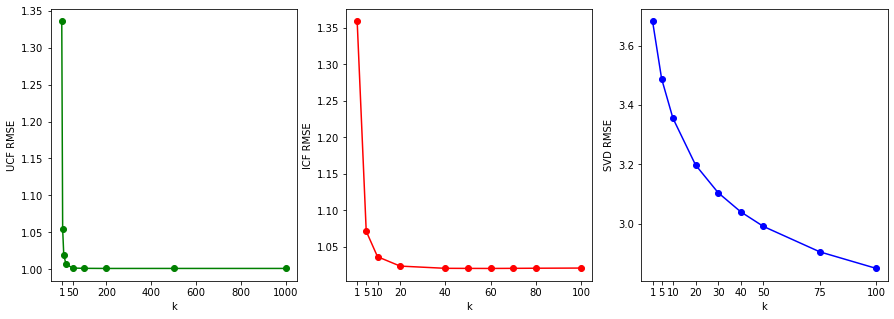

In [9]:
import matplotlib.pyplot as plt

# plotting
plt.figure(figsize = (15,5))
plt.subplot(1, 3, 1)
plt.plot(UCF_k_values, UCF_RMSE, marker='o', color='g')
plt.ylabel('UCF RMSE')
plt.xlabel('k')
plt.xticks([1, 50, 200, 400, 600, 800, 1000]) # the values I think that need to be pointed out
plt.subplot(1, 3, 2)
plt.plot(ICF_k_values, ICF_RMSE, marker='o', color='r')
plt.ylabel('ICF RMSE')
plt.xlabel('k')
plt.xticks([1, 5, 10, 20, 40, 60, 80, 100])
plt.subplot(1, 3, 3)
plt.plot(SVD_k_values, SVD_RMSE, marker='o', color='b')
plt.ylabel('SVD RMSE')
plt.xlabel('k')
plt.xticks([1, 5, 10, 20, 30, 40, 50, 75, 100])
plt.show()

We notice that the error for the funtions ICF and UCF remains almost the same after a certain point with small k values, so I repeat the evaluation of these method for very small k values (zoomed-in version).

In [10]:
zoomed_in_UCF_k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
zoomed_in_ICF_k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

zoomed_in_UCF_RMSE = []
zoomed_in_ICF_RMSE = []

for k in zoomed_in_UCF_k_values:
    zoomed_in_UCF_RMSE.append(calculate_RMSE(removedRatings, UCF(k)))
    
for k in zoomed_in_ICF_k_values:
    zoomed_in_ICF_RMSE.append(calculate_RMSE(removedRatings, ICF(k)))

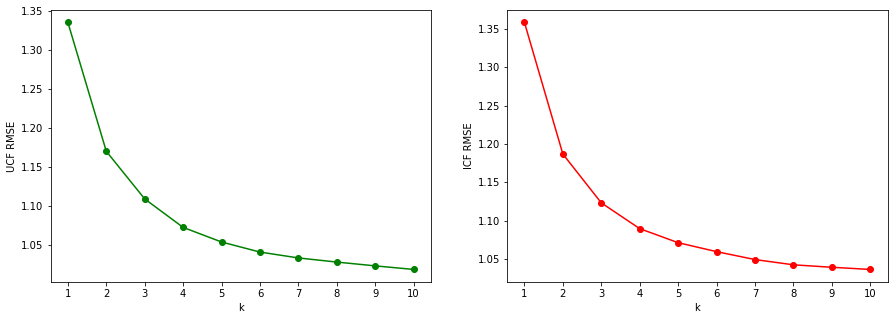

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.plot(zoomed_in_UCF_k_values, zoomed_in_UCF_RMSE, marker='o', color='g')
plt.ylabel('UCF RMSE')
plt.xlabel('k')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.subplot(1, 2, 2)
plt.plot(zoomed_in_ICF_k_values, zoomed_in_ICF_RMSE, marker='o', color='r')
plt.ylabel('ICF RMSE')
plt.xlabel('k')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

Bellow I implement the functions of the baseline values calculation, User Average and Business Average.

In [12]:
# User Average (UA)

def UA():
    predicted_missing_ratings = []
    R_Array = R.toarray()

    for u in removedUserPositions:
        listOfBusinesses = user_has_reviewed[u] # the user_has_reviewed dictionary maps each user index to the business indices of the businesses that the user has rated
        user_ratings = []
        
        for i in range(len(listOfBusinesses)):
            user_ratings.append(R_Array[u][listOfBusinesses[i]])
            
        user_ratings = np.array(user_ratings)
        predicted_missing_ratings.append(np.mean(user_ratings))
        
    return predicted_missing_ratings
        
predictions = UA() # testing the method

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] ) 
        

Removed rating:  3.0  Prediction:  3.863013698630137
Removed rating:  4.0  Prediction:  3.7142857142857144
Removed rating:  5.0  Prediction:  4.074074074074074
Removed rating:  3.0  Prediction:  4.033333333333333
Removed rating:  2.0  Prediction:  2.7058823529411766
Removed rating:  3.0  Prediction:  3.923076923076923
Removed rating:  4.0  Prediction:  3.753623188405797
Removed rating:  4.0  Prediction:  2.890625
Removed rating:  4.0  Prediction:  4.103448275862069
Removed rating:  3.0  Prediction:  3.4285714285714284
Removed rating:  4.0  Prediction:  3.823529411764706
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.5641025641025643
Removed rating:  3.0  Prediction:  3.6623376623376624
Removed rating:  4.0  Prediction:  3.801526717557252
Removed rating:  1.0  Prediction:  3.5789473684210527
Removed rating:  3.0  Prediction:  4.239583333333333
Removed rating:  4.0  Prediction:  3.648068669527897
Removed rating:  5.0  Prediction:  4.6
Removed rating:  4.0  Pr

Removed rating:  5.0  Prediction:  4.014705882352941
Removed rating:  5.0  Prediction:  4.1257861635220126
Removed rating:  1.0  Prediction:  3.586206896551724
Removed rating:  4.0  Prediction:  3.191011235955056
Removed rating:  1.0  Prediction:  2.8666666666666667
Removed rating:  3.0  Prediction:  4.01360544217687
Removed rating:  4.0  Prediction:  3.888888888888889
Removed rating:  3.0  Prediction:  3.389473684210526
Removed rating:  3.0  Prediction:  3.588888888888889
Removed rating:  5.0  Prediction:  3.896551724137931
Removed rating:  3.0  Prediction:  3.317757009345794
Removed rating:  3.0  Prediction:  3.8333333333333335
Removed rating:  4.0  Prediction:  3.744186046511628
Removed rating:  4.0  Prediction:  4.144208037825059
Removed rating:  3.0  Prediction:  3.9
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.9473684210526314
Removed rating:  4.0  Prediction:  3.651282051282051
Removed rating:  4.0  Prediction:  3.7083333333333335
Removed rating:  

Removed rating:  4.0  Prediction:  3.572463768115942
Removed rating:  4.0  Prediction:  3.559322033898305
Removed rating:  3.0  Prediction:  4.108108108108108
Removed rating:  4.0  Prediction:  3.792682926829268
Removed rating:  4.0  Prediction:  3.754385964912281
Removed rating:  3.0  Prediction:  3.7752808988764044
Removed rating:  4.0  Prediction:  3.8
Removed rating:  4.0  Prediction:  3.4324324324324325
Removed rating:  2.0  Prediction:  3.4651162790697674
Removed rating:  4.0  Prediction:  3.5660377358490565
Removed rating:  4.0  Prediction:  3.933333333333333
Removed rating:  4.0  Prediction:  4.105263157894737
Removed rating:  3.0  Prediction:  4.090909090909091
Removed rating:  3.0  Prediction:  3.9766666666666666
Removed rating:  2.0  Prediction:  3.0770877944325483
Removed rating:  3.0  Prediction:  4.1875
Removed rating:  3.0  Prediction:  3.3484320557491287
Removed rating:  5.0  Prediction:  4.2
Removed rating:  5.0  Prediction:  4.153846153846154
Removed rating:  1.0  Pre

Removed rating:  2.0  Prediction:  3.3636363636363638
Removed rating:  3.0  Prediction:  3.7586206896551726
Removed rating:  3.0  Prediction:  3.182926829268293
Removed rating:  4.0  Prediction:  3.847560975609756
Removed rating:  2.0  Prediction:  3.610062893081761
Removed rating:  5.0  Prediction:  3.8222222222222224
Removed rating:  5.0  Prediction:  2.9523809523809526
Removed rating:  4.0  Prediction:  3.3942028985507244
Removed rating:  5.0  Prediction:  4.294117647058823
Removed rating:  5.0  Prediction:  4.25
Removed rating:  3.0  Prediction:  3.99468085106383
Removed rating:  5.0  Prediction:  3.8666666666666667
Removed rating:  4.0  Prediction:  4.4423076923076925
Removed rating:  3.0  Prediction:  3.627906976744186
Removed rating:  3.0  Prediction:  3.6923076923076925
Removed rating:  3.0  Prediction:  3.0588235294117645
Removed rating:  5.0  Prediction:  3.3055555555555554
Removed rating:  4.0  Prediction:  3.8956521739130436
Removed rating:  2.0  Prediction:  3.156626506024

Removed rating:  3.0  Prediction:  4.076923076923077
Removed rating:  3.0  Prediction:  4.014705882352941
Removed rating:  5.0  Prediction:  4.392857142857143
Removed rating:  4.0  Prediction:  3.66025641025641
Removed rating:  4.0  Prediction:  4.066666666666666
Removed rating:  5.0  Prediction:  3.8461538461538463
Removed rating:  4.0  Prediction:  3.6129032258064515
Removed rating:  5.0  Prediction:  3.769230769230769
Removed rating:  3.0  Prediction:  4.3
Removed rating:  2.0  Prediction:  3.353982300884956
Removed rating:  3.0  Prediction:  3.6666666666666665
Removed rating:  4.0  Prediction:  4.2272727272727275
Removed rating:  3.0  Prediction:  3.467289719626168
Removed rating:  4.0  Prediction:  3.614678899082569
Removed rating:  4.0  Prediction:  3.25
Removed rating:  5.0  Prediction:  3.9
Removed rating:  4.0  Prediction:  3.8095238095238093
Removed rating:  4.0  Prediction:  4.071428571428571
Removed rating:  5.0  Prediction:  4.3125
Removed rating:  5.0  Prediction:  3.7209

Removed rating:  2.0  Prediction:  3.88
Removed rating:  4.0  Prediction:  3.4166666666666665
Removed rating:  4.0  Prediction:  3.5853658536585367
Removed rating:  3.0  Prediction:  2.813953488372093
Removed rating:  2.0  Prediction:  4.423076923076923
Removed rating:  5.0  Prediction:  3.792682926829268
Removed rating:  5.0  Prediction:  2.7058823529411766
Removed rating:  4.0  Prediction:  3.7557251908396947
Removed rating:  4.0  Prediction:  3.7435897435897436
Removed rating:  3.0  Prediction:  3.3653846153846154
Removed rating:  4.0  Prediction:  3.736842105263158
Removed rating:  5.0  Prediction:  3.5625
Removed rating:  4.0  Prediction:  4.392857142857143
Removed rating:  3.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  4.0
Removed rating:  1.0  Prediction:  2.611111111111111
Removed rating:  5.0  Prediction:  4.220338983050848
Removed rating:  4.0  Prediction:  3.8421052631578947
Removed rating:  4.0  Prediction:  3.5606060606060606
Removed rating:  2.0  Prediction:  2.

Removed rating:  4.0  Prediction:  3.260869565217391
Removed rating:  4.0  Prediction:  3.6555555555555554
Removed rating:  3.0  Prediction:  3.9625
Removed rating:  2.0  Prediction:  3.3942028985507244
Removed rating:  2.0  Prediction:  3.1481481481481484
Removed rating:  4.0  Prediction:  3.870967741935484
Removed rating:  4.0  Prediction:  3.357142857142857
Removed rating:  4.0  Prediction:  3.62
Removed rating:  4.0  Prediction:  3.641509433962264
Removed rating:  4.0  Prediction:  3.8125
Removed rating:  4.0  Prediction:  3.3333333333333335
Removed rating:  4.0  Prediction:  3.9
Removed rating:  1.0  Prediction:  1.9411764705882353
Removed rating:  4.0  Prediction:  3.7557251908396947
Removed rating:  3.0  Prediction:  3.754385964912281
Removed rating:  3.0  Prediction:  3.6956521739130435
Removed rating:  4.0  Prediction:  4.275862068965517
Removed rating:  2.0  Prediction:  3.84
Removed rating:  4.0  Prediction:  3.642857142857143
Removed rating:  4.0  Prediction:  3.90714285714

Removed rating:  5.0  Prediction:  4.074074074074074
Removed rating:  5.0  Prediction:  3.611111111111111
Removed rating:  4.0  Prediction:  3.754385964912281
Removed rating:  5.0  Prediction:  3.1538461538461537
Removed rating:  5.0  Prediction:  4.144208037825059
Removed rating:  4.0  Prediction:  3.5238095238095237
Removed rating:  4.0  Prediction:  3.6666666666666665
Removed rating:  2.0  Prediction:  3.6686046511627906
Removed rating:  4.0  Prediction:  3.7435897435897436
Removed rating:  5.0  Prediction:  3.588235294117647
Removed rating:  3.0  Prediction:  3.0120481927710845
Removed rating:  4.0  Prediction:  3.8295454545454546
Removed rating:  5.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  3.0153846153846153
Removed rating:  4.0  Prediction:  3.6
Removed rating:  4.0  Prediction:  4.318518518518519
Removed rating:  4.0  Prediction:  3.5538461538461537
Removed rating:  4.0  Prediction:  3.5142857142857142
Removed rating:  4.0  Prediction:  3.0
Removed rating:  4.0  Pre

Removed rating:  3.0  Prediction:  3.7066666666666666
Removed rating:  5.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  4.247311827956989
Removed rating:  5.0  Prediction:  3.6
Removed rating:  3.0  Prediction:  2.933333333333333
Removed rating:  5.0  Prediction:  3.803921568627451
Removed rating:  3.0  Prediction:  3.1666666666666665
Removed rating:  4.0  Prediction:  3.111111111111111
Removed rating:  4.0  Prediction:  3.1666666666666665
Removed rating:  3.0  Prediction:  3.1170483460559795
Removed rating:  4.0  Prediction:  3.35
Removed rating:  3.0  Prediction:  3.0816326530612246
Removed rating:  4.0  Prediction:  3.642857142857143
Removed rating:  4.0  Prediction:  3.6666666666666665
Removed rating:  2.0  Prediction:  3.526315789473684
Removed rating:  1.0  Prediction:  3.3181818181818183
Removed rating:  3.0  Prediction:  4.105263157894737
Removed rating:  4.0  Prediction:  3.41025641025641
Removed rating:  2.0  Prediction:  3.5294117647058822
Removed rating:  5.0  Predi

Removed rating:  2.0  Prediction:  3.6956521739130435
Removed rating:  1.0  Prediction:  3.533333333333333
Removed rating:  4.0  Prediction:  3.964028776978417
Removed rating:  4.0  Prediction:  3.0
Removed rating:  4.0  Prediction:  3.5217391304347827
Removed rating:  4.0  Prediction:  3.771573604060914
Removed rating:  5.0  Prediction:  3.9375
Removed rating:  3.0  Prediction:  3.3923076923076922
Removed rating:  3.0  Prediction:  3.891304347826087
Removed rating:  5.0  Prediction:  4.274193548387097
Removed rating:  5.0  Prediction:  3.88
Removed rating:  3.0  Prediction:  4.09433962264151
Removed rating:  4.0  Prediction:  3.380952380952381
Removed rating:  4.0  Prediction:  3.2586206896551726
Removed rating:  4.0  Prediction:  3.8842105263157896
Removed rating:  3.0  Prediction:  3.782608695652174
Removed rating:  2.0  Prediction:  3.75
Removed rating:  4.0  Prediction:  3.6578947368421053
Removed rating:  5.0  Prediction:  3.427480916030534
Removed rating:  4.0  Prediction:  4.0


Removed rating:  2.0  Prediction:  3.713636363636364
Removed rating:  1.0  Prediction:  3.4482758620689653
Removed rating:  4.0  Prediction:  4.214285714285714
Removed rating:  5.0  Prediction:  3.789473684210526
Removed rating:  3.0  Prediction:  3.5522388059701493
Removed rating:  3.0  Prediction:  3.86046511627907
Removed rating:  4.0  Prediction:  3.6
Removed rating:  1.0  Prediction:  3.4081632653061225
Removed rating:  5.0  Prediction:  3.670886075949367
Removed rating:  5.0  Prediction:  3.4444444444444446
Removed rating:  4.0  Prediction:  3.7142857142857144
Removed rating:  4.0  Prediction:  3.848101265822785
Removed rating:  4.0  Prediction:  3.85
Removed rating:  3.0  Prediction:  3.625
Removed rating:  3.0  Prediction:  3.326923076923077
Removed rating:  4.0  Prediction:  3.74468085106383
Removed rating:  3.0  Prediction:  3.828125
Removed rating:  4.0  Prediction:  4.923076923076923
Removed rating:  3.0  Prediction:  3.7818181818181817
Removed rating:  3.0  Prediction:  3.

Removed rating:  5.0  Prediction:  1.5
Removed rating:  1.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  4.2105263157894735
Removed rating:  4.0  Prediction:  3.3707865168539324
Removed rating:  5.0  Prediction:  3.35
Removed rating:  4.0  Prediction:  3.4838709677419355
Removed rating:  3.0  Prediction:  3.3923076923076922
Removed rating:  4.0  Prediction:  3.9375
Removed rating:  4.0  Prediction:  3.754385964912281
Removed rating:  1.0  Prediction:  4.076923076923077
Removed rating:  3.0  Prediction:  3.88
Removed rating:  4.0  Prediction:  3.8461538461538463
Removed rating:  4.0  Prediction:  2.5833333333333335
Removed rating:  2.0  Prediction:  3.5483870967741935
Removed rating:  5.0  Prediction:  4.214285714285714
Removed rating:  5.0  Prediction:  2.830188679245283
Removed rating:  2.0  Prediction:  3.0952380952380953
Removed rating:  5.0  Prediction:  3.8684210526315788
Removed rating:  4.0  Prediction:  4.045112781954887
Removed rating:  4.0  Prediction:  3.969696969696

Removed rating:  4.0  Prediction:  3.5323383084577116
Removed rating:  5.0  Prediction:  3.3333333333333335
Removed rating:  5.0  Prediction:  2.8125
Removed rating:  4.0  Prediction:  3.527173913043478
Removed rating:  4.0  Prediction:  3.625
Removed rating:  5.0  Prediction:  3.3055555555555554
Removed rating:  3.0  Prediction:  3.764705882352941
Removed rating:  5.0  Prediction:  3.619047619047619
Removed rating:  4.0  Prediction:  3.3369565217391304
Removed rating:  3.0  Prediction:  3.4693140794223827
Removed rating:  3.0  Prediction:  3.8256880733944953
Removed rating:  2.0  Prediction:  3.8055555555555554
Removed rating:  5.0  Prediction:  3.6142857142857143
Removed rating:  4.0  Prediction:  3.725
Removed rating:  4.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.9411764705882355
Removed rating:  4.0  Prediction:  4.138461538461539
Removed rating:  4.0  Prediction:  3.2
Removed rating:  3.0  Prediction:  3.923076923076923
Removed rating:  4.0  Prediction:  3.8014705882

Removed rating:  4.0  Prediction:  3.9722222222222223
Removed rating:  5.0  Prediction:  3.9473684210526314
Removed rating:  3.0  Prediction:  3.6
Removed rating:  5.0  Prediction:  4.111111111111111
Removed rating:  4.0  Prediction:  3.651282051282051
Removed rating:  4.0  Prediction:  3.8636363636363638
Removed rating:  3.0  Prediction:  3.5833333333333335
Removed rating:  3.0  Prediction:  3.25
Removed rating:  4.0  Prediction:  4.333333333333333
Removed rating:  3.0  Prediction:  3.2975206611570247
Removed rating:  5.0  Prediction:  4.444444444444445
Removed rating:  4.0  Prediction:  3.719178082191781
Removed rating:  1.0  Prediction:  2.813953488372093
Removed rating:  5.0  Prediction:  4.130434782608695
Removed rating:  4.0  Prediction:  4.304347826086956
Removed rating:  4.0  Prediction:  3.5126760563380284
Removed rating:  3.0  Prediction:  3.4411764705882355
Removed rating:  4.0  Prediction:  3.8333333333333335
Removed rating:  2.0  Prediction:  3.7
Removed rating:  5.0  Pred

Removed rating:  5.0  Prediction:  3.6728971962616823
Removed rating:  4.0  Prediction:  3.933333333333333
Removed rating:  1.0  Prediction:  3.955223880597015
Removed rating:  2.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  3.875
Removed rating:  2.0  Prediction:  3.1012658227848102
Removed rating:  3.0  Prediction:  3.188679245283019
Removed rating:  3.0  Prediction:  3.458904109589041
Removed rating:  4.0  Prediction:  4.083333333333333
Removed rating:  3.0  Prediction:  3.9846153846153847
Removed rating:  4.0  Prediction:  3.9766666666666666
Removed rating:  4.0  Prediction:  3.375
Removed rating:  3.0  Prediction:  3.782608695652174
Removed rating:  4.0  Prediction:  4.144208037825059
Removed rating:  4.0  Prediction:  2.813953488372093
Removed rating:  5.0  Prediction:  4.2894736842105265
Removed rating:  3.0  Prediction:  3.2325581395348837
Removed rating:  5.0  Prediction:  3.764705882352941
Removed rating:  5.0  Prediction:  3.4857142857142858
Removed rating:  4.0  Pr

Removed rating:  3.0  Prediction:  3.3942028985507244
Removed rating:  5.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  3.5652173913043477
Removed rating:  4.0  Prediction:  4.230769230769231
Removed rating:  5.0  Prediction:  4.363636363636363
Removed rating:  4.0  Prediction:  3.869565217391304
Removed rating:  5.0  Prediction:  3.551282051282051
Removed rating:  4.0  Prediction:  3.9
Removed rating:  4.0  Prediction:  3.4285714285714284
Removed rating:  4.0  Prediction:  3.5714285714285716
Removed rating:  4.0  Prediction:  3.8
Removed rating:  4.0  Prediction:  3.4545454545454546
Removed rating:  5.0  Prediction:  3.78125
Removed rating:  3.0  Prediction:  3.0
Removed rating:  4.0  Prediction:  4.2
Removed rating:  4.0  Prediction:  3.4
Removed rating:  4.0  Prediction:  3.242424242424242
Removed rating:  4.0  Prediction:  3.5384615384615383
Removed rating:  4.0  Prediction:  3.2222222222222223
Removed rating:  3.0  Prediction:  3.3125
Removed rating:  4.0  Prediction:  4.6

Removed rating:  4.0  Prediction:  3.4927536231884058
Removed rating:  5.0  Prediction:  3.75
Removed rating:  1.0  Prediction:  4.179775280898877
Removed rating:  5.0  Prediction:  3.5434782608695654
Removed rating:  3.0  Prediction:  3.7260273972602738
Removed rating:  4.0  Prediction:  4.17910447761194
Removed rating:  5.0  Prediction:  3.677685950413223
Removed rating:  3.0  Prediction:  4.073170731707317
Removed rating:  1.0  Prediction:  3.7222222222222223
Removed rating:  4.0  Prediction:  3.280701754385965
Removed rating:  3.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  4.033333333333333
Removed rating:  5.0  Prediction:  3.55
Removed rating:  5.0  Prediction:  3.8666666666666667
Removed rating:  4.0  Prediction:  4.1891891891891895
Removed rating:  1.0  Prediction:  3.409090909090909
Removed rating:  3.0  Prediction:  3.6666666666666665
Removed rating:  3.0  Prediction:  3.443396226415094
Removed rating:  3.0  Prediction:  4.3125
Removed rating:  3.0  Prediction:  3.5

Removed rating:  3.0  Prediction:  3.5660377358490565
Removed rating:  4.0  Prediction:  3.876923076923077
Removed rating:  3.0  Prediction:  3.2149532710280373
Removed rating:  5.0  Prediction:  4.368421052631579
Removed rating:  4.0  Prediction:  3.506666666666667
Removed rating:  4.0  Prediction:  4.129032258064516
Removed rating:  3.0  Prediction:  3.9411764705882355
Removed rating:  4.0  Prediction:  4.1257861635220126
Removed rating:  5.0  Prediction:  3.9657142857142857
Removed rating:  5.0  Prediction:  3.4444444444444446
Removed rating:  3.0  Prediction:  3.9491525423728815
Removed rating:  5.0  Prediction:  3.8666666666666667
Removed rating:  5.0  Prediction:  4.3428571428571425
Removed rating:  4.0  Prediction:  3.1785714285714284
Removed rating:  3.0  Prediction:  3.5483870967741935
Removed rating:  1.0  Prediction:  3.2837837837837838
Removed rating:  4.0  Prediction:  3.4943181818181817
Removed rating:  2.0  Prediction:  3.7857142857142856
Removed rating:  4.0  Prediction

Removed rating:  5.0  Prediction:  3.887323943661972
Removed rating:  4.0  Prediction:  3.4285714285714284
Removed rating:  3.0  Prediction:  3.558659217877095
Removed rating:  3.0  Prediction:  3.527173913043478
Removed rating:  5.0  Prediction:  3.923076923076923
Removed rating:  5.0  Prediction:  4.074074074074074
Removed rating:  4.0  Prediction:  3.4215686274509802
Removed rating:  2.0  Prediction:  3.0
Removed rating:  4.0  Prediction:  3.9047619047619047
Removed rating:  3.0  Prediction:  3.467289719626168
Removed rating:  5.0  Prediction:  3.5728155339805827
Removed rating:  3.0  Prediction:  3.43312101910828
Removed rating:  4.0  Prediction:  3.8256880733944953
Removed rating:  4.0  Prediction:  3.6285714285714286
Removed rating:  4.0  Prediction:  3.890625
Removed rating:  4.0  Prediction:  3.4347826086956523
Removed rating:  3.0  Prediction:  3.7674418604651163
Removed rating:  5.0  Prediction:  3.3225806451612905
Removed rating:  5.0  Prediction:  3.769230769230769
Removed 

Removed rating:  3.0  Prediction:  3.619718309859155
Removed rating:  3.0  Prediction:  3.2705882352941176
Removed rating:  4.0  Prediction:  3.855769230769231
Removed rating:  4.0  Prediction:  3.5681818181818183
Removed rating:  5.0  Prediction:  3.8365384615384617
Removed rating:  3.0  Prediction:  3.456140350877193
Removed rating:  2.0  Prediction:  3.9375
Removed rating:  5.0  Prediction:  3.88
Removed rating:  5.0  Prediction:  4.266666666666667
Removed rating:  4.0  Prediction:  3.5357142857142856
Removed rating:  4.0  Prediction:  2.9375
Removed rating:  4.0  Prediction:  3.5248618784530388
Removed rating:  3.0  Prediction:  3.743362831858407
Removed rating:  5.0  Prediction:  4.055555555555555
Removed rating:  2.0  Prediction:  3.526315789473684
Removed rating:  4.0  Prediction:  3.7851239669421486
Removed rating:  4.0  Prediction:  3.230769230769231
Removed rating:  3.0  Prediction:  3.4375
Removed rating:  3.0  Prediction:  3.435251798561151
Removed rating:  4.0  Prediction:

Removed rating:  4.0  Prediction:  4.027777777777778
Removed rating:  3.0  Prediction:  3.358974358974359
Removed rating:  5.0  Prediction:  3.9766666666666666
Removed rating:  2.0  Prediction:  3.4565217391304346
Removed rating:  4.0  Prediction:  3.8842105263157896
Removed rating:  4.0  Prediction:  4.09375
Removed rating:  3.0  Prediction:  3.75
Removed rating:  4.0  Prediction:  3.9473684210526314
Removed rating:  3.0  Prediction:  3.3707865168539324
Removed rating:  5.0  Prediction:  3.963302752293578
Removed rating:  4.0  Prediction:  3.5106382978723403
Removed rating:  4.0  Prediction:  3.5714285714285716
Removed rating:  4.0  Prediction:  2.6666666666666665
Removed rating:  4.0  Prediction:  4.208333333333333
Removed rating:  4.0  Prediction:  3.8947368421052633
Removed rating:  4.0  Prediction:  4.368421052631579
Removed rating:  3.0  Prediction:  3.227272727272727
Removed rating:  2.0  Prediction:  4.2592592592592595
Removed rating:  5.0  Prediction:  3.5
Removed rating:  4.0

Removed rating:  4.0  Prediction:  3.5277777777777777
Removed rating:  1.0  Prediction:  2.625
Removed rating:  5.0  Prediction:  4.666666666666667
Removed rating:  5.0  Prediction:  4.2894736842105265
Removed rating:  5.0  Prediction:  4.129032258064516
Removed rating:  5.0  Prediction:  4.384615384615385
Removed rating:  4.0  Prediction:  3.5145631067961167
Removed rating:  5.0  Prediction:  3.145631067961165
Removed rating:  3.0  Prediction:  3.0930232558139537
Removed rating:  3.0  Prediction:  3.744186046511628
Removed rating:  2.0  Prediction:  3.7142857142857144
Removed rating:  3.0  Prediction:  3.8125
Removed rating:  3.0  Prediction:  3.754385964912281
Removed rating:  4.0  Prediction:  3.96
Removed rating:  4.0  Prediction:  3.1523809523809523
Removed rating:  5.0  Prediction:  3.1923076923076925
Removed rating:  3.0  Prediction:  3.4823529411764707
Removed rating:  4.0  Prediction:  3.40625
Removed rating:  4.0  Prediction:  3.7916666666666665
Removed rating:  4.0  Predicti

Removed rating:  2.0  Prediction:  3.3142857142857145
Removed rating:  5.0  Prediction:  3.743362831858407
Removed rating:  4.0  Prediction:  3.5
Removed rating:  4.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  3.5
Removed rating:  2.0  Prediction:  3.5405405405405403
Removed rating:  2.0  Prediction:  2.84375
Removed rating:  4.0  Prediction:  4.045112781954887
Removed rating:  3.0  Prediction:  3.5813953488372094
Removed rating:  4.0  Prediction:  3.533333333333333
Removed rating:  3.0  Prediction:  3.6990291262135924
Removed rating:  4.0  Prediction:  3.4976958525345623
Removed rating:  3.0  Prediction:  3.353982300884956
Removed rating:  4.0  Prediction:  3.953846153846154
Removed rating:  3.0  Prediction:  3.7333333333333334
Removed rating:  4.0  Prediction:  3.772727272727273
Removed rating:  5.0  Prediction:  3.4722222222222223
Removed rating:  4.0  Prediction:  3.5783132530120483
Removed rating:  4.0  Prediction:  3.5126760563380284
Removed rating:  3.0  Prediction:  4

Removed rating:  4.0  Prediction:  3.725
Removed rating:  3.0  Prediction:  3.831858407079646
Removed rating:  3.0  Prediction:  4.121212121212121
Removed rating:  4.0  Prediction:  3.2625
Removed rating:  4.0  Prediction:  3.6842105263157894
Removed rating:  1.0  Prediction:  2.142857142857143
Removed rating:  4.0  Prediction:  3.5
Removed rating:  4.0  Prediction:  3.2857142857142856
Removed rating:  1.0  Prediction:  2.6666666666666665
Removed rating:  4.0  Prediction:  3.6363636363636362
Removed rating:  3.0  Prediction:  4.144208037825059
Removed rating:  5.0  Prediction:  3.596774193548387
Removed rating:  2.0  Prediction:  3.744186046511628
Removed rating:  3.0  Prediction:  3.5142857142857142
Removed rating:  5.0  Prediction:  3.608695652173913
Removed rating:  4.0  Prediction:  3.754385964912281
Removed rating:  3.0  Prediction:  3.918032786885246
Removed rating:  3.0  Prediction:  3.765957446808511
Removed rating:  5.0  Prediction:  3.7153846153846155
Removed rating:  5.0  Pr

Removed rating:  3.0  Prediction:  3.9615384615384617
Removed rating:  4.0  Prediction:  3.6555555555555554
Removed rating:  3.0  Prediction:  3.648068669527897
Removed rating:  3.0  Prediction:  3.269230769230769
Removed rating:  2.0  Prediction:  2.8518518518518516
Removed rating:  4.0  Prediction:  3.435251798561151
Removed rating:  1.0  Prediction:  3.642857142857143
Removed rating:  3.0  Prediction:  3.7916666666666665
Removed rating:  4.0  Prediction:  2.725
Removed rating:  4.0  Prediction:  3.413793103448276
Removed rating:  4.0  Prediction:  3.5945945945945947
Removed rating:  5.0  Prediction:  3.145631067961165
Removed rating:  2.0  Prediction:  3.980392156862745
Removed rating:  5.0  Prediction:  4.2894736842105265
Removed rating:  3.0  Prediction:  3.6419753086419755
Removed rating:  4.0  Prediction:  3.527027027027027
Removed rating:  3.0  Prediction:  3.3488372093023258
Removed rating:  3.0  Prediction:  3.814814814814815
Removed rating:  5.0  Prediction:  3.2666666666666

Removed rating:  5.0  Prediction:  3.8333333333333335
Removed rating:  5.0  Prediction:  3.8516483516483517
Removed rating:  3.0  Prediction:  3.2937062937062938
Removed rating:  4.0  Prediction:  3.051282051282051
Removed rating:  5.0  Prediction:  4.36734693877551
Removed rating:  4.0  Prediction:  3.6973684210526314
Removed rating:  3.0  Prediction:  3.7586206896551726
Removed rating:  5.0  Prediction:  4.0227272727272725
Removed rating:  3.0  Prediction:  3.5338345864661656
Removed rating:  5.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  3.559322033898305
Removed rating:  2.0  Prediction:  4.027777777777778
Removed rating:  3.0  Prediction:  3.4545454545454546
Removed rating:  4.0  Prediction:  3.8125
Removed rating:  3.0  Prediction:  3.619047619047619
Removed rating:  3.0  Prediction:  3.3144654088050314
Removed rating:  5.0  Prediction:  3.7333333333333334
Removed rating:  4.0  Prediction:  3.28125
Removed rating:  4.0  Prediction:  3.694267515923567
Removed rating:  5.

Removed rating:  4.0  Prediction:  3.8516483516483517
Removed rating:  2.0  Prediction:  3.7386363636363638
Removed rating:  1.0  Prediction:  3.4107142857142856
Removed rating:  5.0  Prediction:  4.076782449725777
Removed rating:  4.0  Prediction:  3.849056603773585
Removed rating:  5.0  Prediction:  3.9411764705882355
Removed rating:  5.0  Prediction:  3.358974358974359
Removed rating:  2.0  Prediction:  3.0770877944325483
Removed rating:  3.0  Prediction:  3.7142857142857144
Removed rating:  4.0  Prediction:  4.142857142857143
Removed rating:  3.0  Prediction:  3.3942028985507244
Removed rating:  5.0  Prediction:  4.571428571428571
Removed rating:  3.0  Prediction:  3.2222222222222223
Removed rating:  4.0  Prediction:  3.471264367816092
Removed rating:  4.0  Prediction:  3.263157894736842
Removed rating:  4.0  Prediction:  3.280701754385965
Removed rating:  4.0  Prediction:  4.0588235294117645
Removed rating:  4.0  Prediction:  3.869565217391304
Removed rating:  5.0  Prediction:  4.

Removed rating:  3.0  Prediction:  4.166666666666667
Removed rating:  5.0  Prediction:  4.033333333333333
Removed rating:  4.0  Prediction:  3.6826923076923075
Removed rating:  4.0  Prediction:  3.4107142857142856
Removed rating:  4.0  Prediction:  3.5652173913043477
Removed rating:  1.0  Prediction:  3.7777777777777777
Removed rating:  4.0  Prediction:  3.5126760563380284
Removed rating:  4.0  Prediction:  3.923076923076923
Removed rating:  2.0  Prediction:  2.9444444444444446
Removed rating:  4.0  Prediction:  3.9696969696969697
Removed rating:  5.0  Prediction:  4.619047619047619
Removed rating:  1.0  Prediction:  3.2666666666666666
Removed rating:  5.0  Prediction:  3.7
Removed rating:  4.0  Prediction:  4.365853658536586
Removed rating:  5.0  Prediction:  3.857142857142857
Removed rating:  4.0  Prediction:  4.266666666666667
Removed rating:  4.0  Prediction:  3.78125
Removed rating:  4.0  Prediction:  3.615894039735099
Removed rating:  4.0  Prediction:  3.791208791208791
Removed r

Removed rating:  4.0  Prediction:  3.5912698412698414
Removed rating:  5.0  Prediction:  3.6153846153846154
Removed rating:  4.0  Prediction:  4.379310344827586
Removed rating:  2.0  Prediction:  3.789473684210526
Removed rating:  2.0  Prediction:  3.5972222222222223
Removed rating:  4.0  Prediction:  3.6923076923076925
Removed rating:  1.0  Prediction:  3.2444444444444445
Removed rating:  3.0  Prediction:  3.36
Removed rating:  4.0  Prediction:  3.4674418604651165
Removed rating:  4.0  Prediction:  3.4705882352941178
Removed rating:  5.0  Prediction:  4.202898550724638
Removed rating:  5.0  Prediction:  3.3541666666666665
Removed rating:  5.0  Prediction:  4.368421052631579
Removed rating:  5.0  Prediction:  3.7231638418079096
Removed rating:  4.0  Prediction:  4.105263157894737
Removed rating:  2.0  Prediction:  3.66
Removed rating:  4.0  Prediction:  3.771573604060914
Removed rating:  1.0  Prediction:  3.8260869565217392
Removed rating:  4.0  Prediction:  3.6153846153846154
Removed 

Removed rating:  4.0  Prediction:  3.6842105263157894
Removed rating:  4.0  Prediction:  3.8732394366197185
Removed rating:  4.0  Prediction:  3.8666666666666667
Removed rating:  3.0  Prediction:  4.076923076923077
Removed rating:  4.0  Prediction:  3.9518072289156625
Removed rating:  4.0  Prediction:  3.0
Removed rating:  3.0  Prediction:  3.712328767123288
Removed rating:  1.0  Prediction:  3.1818181818181817
Removed rating:  4.0  Prediction:  3.537037037037037
Removed rating:  4.0  Prediction:  3.6710526315789473
Removed rating:  4.0  Prediction:  3.6296296296296298
Removed rating:  5.0  Prediction:  3.7547169811320753
Removed rating:  3.0  Prediction:  3.326530612244898
Removed rating:  3.0  Prediction:  3.3380281690140845
Removed rating:  4.0  Prediction:  3.227272727272727
Removed rating:  3.0  Prediction:  3.5853658536585367
Removed rating:  4.0  Prediction:  3.625
Removed rating:  3.0  Prediction:  4.2
Removed rating:  3.0  Prediction:  3.5426356589147288
Removed rating:  5.0  

Removed rating:  4.0  Prediction:  3.6
Removed rating:  4.0  Prediction:  3.1904761904761907
Removed rating:  3.0  Prediction:  3.38
Removed rating:  3.0  Prediction:  3.4269662921348316
Removed rating:  4.0  Prediction:  3.782178217821782
Removed rating:  5.0  Prediction:  4.3125
Removed rating:  3.0  Prediction:  3.6363636363636362
Removed rating:  5.0  Prediction:  4.3076923076923075
Removed rating:  3.0  Prediction:  4.066666666666666
Removed rating:  2.0  Prediction:  2.2666666666666666
Removed rating:  3.0  Prediction:  3.7033898305084745
Removed rating:  5.0  Prediction:  3.6956521739130435
Removed rating:  4.0  Prediction:  3.7058823529411766
Removed rating:  4.0  Prediction:  3.5853658536585367
Removed rating:  4.0  Prediction:  3.5428571428571427
Removed rating:  5.0  Prediction:  3.7559055118110236
Removed rating:  4.0  Prediction:  4.031746031746032
Removed rating:  5.0  Prediction:  4.027777777777778
Removed rating:  4.0  Prediction:  3.7567567567567566
Removed rating:  5.

Removed rating:  4.0  Prediction:  4.117647058823529
Removed rating:  3.0  Prediction:  4.15
Removed rating:  5.0  Prediction:  2.5
Removed rating:  4.0  Prediction:  3.4010471204188484
Removed rating:  5.0  Prediction:  4.354838709677419
Removed rating:  3.0  Prediction:  3.727272727272727
Removed rating:  3.0  Prediction:  4.111111111111111
Removed rating:  4.0  Prediction:  3.771573604060914
Removed rating:  2.0  Prediction:  3.909090909090909
Removed rating:  4.0  Prediction:  3.1566265060240966
Removed rating:  5.0  Prediction:  3.857142857142857
Removed rating:  3.0  Prediction:  3.4680851063829787
Removed rating:  5.0  Prediction:  3.772727272727273
Removed rating:  5.0  Prediction:  4.017857142857143
Removed rating:  4.0  Prediction:  3.6493506493506493
Removed rating:  4.0  Prediction:  3.8636363636363638
Removed rating:  2.0  Prediction:  3.8732394366197185
Removed rating:  4.0  Prediction:  3.9523809523809526
Removed rating:  1.0  Prediction:  3.5681818181818183
Removed rati

In [13]:
# Business Average (BA)

def BA():
    predicted_missing_ratings = []
    R_Array = R.toarray()

    for b in removedBusinessPositions:
        usersThatReviewed = business_rated_by[b]
        business_ratings = []
        
        for i in range(len(usersThatReviewed)):
            business_ratings.append(R_Array[usersThatReviewed[i]][b])
        
        business_ratings = np.array(business_ratings)
        predicted_missing_ratings.append(np.mean(business_ratings))
        
    return predicted_missing_ratings

predictions = BA() # testing the method

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] ) 
        

Removed rating:  3.0  Prediction:  3.5643564356435644
Removed rating:  4.0  Prediction:  3.9444444444444446
Removed rating:  5.0  Prediction:  3.056603773584906
Removed rating:  3.0  Prediction:  3.05
Removed rating:  2.0  Prediction:  3.75
Removed rating:  3.0  Prediction:  3.446096654275093
Removed rating:  4.0  Prediction:  3.8232558139534882
Removed rating:  4.0  Prediction:  3.898989898989899
Removed rating:  4.0  Prediction:  3.625
Removed rating:  3.0  Prediction:  3.595744680851064
Removed rating:  4.0  Prediction:  3.6835443037974684
Removed rating:  5.0  Prediction:  3.803921568627451
Removed rating:  4.0  Prediction:  4.5344827586206895
Removed rating:  3.0  Prediction:  3.5
Removed rating:  4.0  Prediction:  3.6814159292035398
Removed rating:  1.0  Prediction:  2.76
Removed rating:  3.0  Prediction:  4.221276595744681
Removed rating:  4.0  Prediction:  3.6303317535545023
Removed rating:  5.0  Prediction:  3.595744680851064
Removed rating:  4.0  Prediction:  3.22580645161290

Removed rating:  3.0  Prediction:  4.2967032967032965
Removed rating:  4.0  Prediction:  3.40625
Removed rating:  4.0  Prediction:  3.775
Removed rating:  4.0  Prediction:  4.142857142857143
Removed rating:  4.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  3.5671641791044775
Removed rating:  2.0  Prediction:  3.5714285714285716
Removed rating:  5.0  Prediction:  4.191780821917808
Removed rating:  1.0  Prediction:  3.125
Removed rating:  1.0  Prediction:  3.5306122448979593
Removed rating:  5.0  Prediction:  3.7724867724867726
Removed rating:  3.0  Prediction:  3.7241379310344827
Removed rating:  5.0  Prediction:  4.264
Removed rating:  5.0  Prediction:  4.328571428571428
Removed rating:  4.0  Prediction:  3.608695652173913
Removed rating:  5.0  Prediction:  4.1434108527131785
Removed rating:  3.0  Prediction:  2.596638655462185
Removed rating:  4.0  Prediction:  3.7465753424657535
Removed rating:  3.0  Prediction:  3.484848484848485
Removed rating:  4.0  Prediction:  3.94148936

Removed rating:  4.0  Prediction:  4.2518518518518515
Removed rating:  3.0  Prediction:  3.779279279279279
Removed rating:  4.0  Prediction:  4.015625
Removed rating:  3.0  Prediction:  3.275
Removed rating:  4.0  Prediction:  3.0
Removed rating:  4.0  Prediction:  4.025806451612903
Removed rating:  4.0  Prediction:  3.962962962962963
Removed rating:  4.0  Prediction:  4.1454545454545455
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.7724867724867726
Removed rating:  4.0  Prediction:  3.3771929824561404
Removed rating:  5.0  Prediction:  3.7450980392156863
Removed rating:  4.0  Prediction:  3.3125
Removed rating:  4.0  Prediction:  3.6344086021505375
Removed rating:  2.0  Prediction:  2.933333333333333
Removed rating:  4.0  Prediction:  3.54
Removed rating:  4.0  Prediction:  3.923076923076923
Removed rating:  4.0  Prediction:  3.388888888888889
Removed rating:  3.0  Prediction:  3.8625
Removed rating:  3.0  Prediction:  3.6440677966101696
Removed rating:  

Removed rating:  4.0  Prediction:  3.7777777777777777
Removed rating:  4.0  Prediction:  3.05
Removed rating:  5.0  Prediction:  4.038461538461538
Removed rating:  4.0  Prediction:  3.953020134228188
Removed rating:  4.0  Prediction:  3.953020134228188
Removed rating:  3.0  Prediction:  2.8
Removed rating:  4.0  Prediction:  3.3333333333333335
Removed rating:  4.0  Prediction:  3.737704918032787
Removed rating:  3.0  Prediction:  3.590909090909091
Removed rating:  4.0  Prediction:  4.125
Removed rating:  4.0  Prediction:  3.2988505747126435
Removed rating:  3.0  Prediction:  4.068965517241379
Removed rating:  4.0  Prediction:  3.7889908256880735
Removed rating:  4.0  Prediction:  4.071428571428571
Removed rating:  4.0  Prediction:  3.375
Removed rating:  4.0  Prediction:  3.403225806451613
Removed rating:  2.0  Prediction:  3.2962962962962963
Removed rating:  4.0  Prediction:  3.8135593220338984
Removed rating:  3.0  Prediction:  3.0416666666666665
Removed rating:  3.0  Prediction:  4.

Removed rating:  3.0  Prediction:  3.6
Removed rating:  4.0  Prediction:  2.918918918918919
Removed rating:  5.0  Prediction:  4.639240506329114
Removed rating:  4.0  Prediction:  3.7777777777777777
Removed rating:  4.0  Prediction:  3.9761904761904763
Removed rating:  3.0  Prediction:  3.264705882352941
Removed rating:  4.0  Prediction:  3.7574750830564785
Removed rating:  5.0  Prediction:  3.8
Removed rating:  4.0  Prediction:  3.760330578512397
Removed rating:  4.0  Prediction:  3.62
Removed rating:  4.0  Prediction:  2.5454545454545454
Removed rating:  4.0  Prediction:  3.4177215189873418
Removed rating:  5.0  Prediction:  3.875
Removed rating:  4.0  Prediction:  3.6470588235294117
Removed rating:  1.0  Prediction:  4.076923076923077
Removed rating:  4.0  Prediction:  3.789473684210526
Removed rating:  5.0  Prediction:  3.7419354838709675
Removed rating:  4.0  Prediction:  3.4634146341463414
Removed rating:  4.0  Prediction:  3.9705882352941178
Removed rating:  4.0  Prediction:  2.

Removed rating:  1.0  Prediction:  2.9545454545454546
Removed rating:  5.0  Prediction:  4.171428571428572
Removed rating:  4.0  Prediction:  3.625
Removed rating:  4.0  Prediction:  4.0476190476190474
Removed rating:  2.0  Prediction:  3.5555555555555554
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.6440677966101696
Removed rating:  4.0  Prediction:  4.0625
Removed rating:  4.0  Prediction:  3.7142857142857144
Removed rating:  3.0  Prediction:  3.235294117647059
Removed rating:  4.0  Prediction:  3.773480662983425
Removed rating:  2.0  Prediction:  3.3714285714285714
Removed rating:  3.0  Prediction:  4.090163934426229
Removed rating:  5.0  Prediction:  4.25
Removed rating:  4.0  Prediction:  2.6511627906976742
Removed rating:  2.0  Prediction:  4.223463687150838
Removed rating:  4.0  Prediction:  3.96943231441048
Removed rating:  5.0  Prediction:  4.2105263157894735
Removed rating:  5.0  Prediction:  4.233333333333333
Removed rating:  4.0  Prediction:  4

Removed rating:  4.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  4.1521739130434785
Removed rating:  2.0  Prediction:  3.977272727272727
Removed rating:  3.0  Prediction:  3.409090909090909
Removed rating:  5.0  Prediction:  3.0303030303030303
Removed rating:  5.0  Prediction:  3.6666666666666665
Removed rating:  4.0  Prediction:  3.732142857142857
Removed rating:  3.0  Prediction:  3.875
Removed rating:  5.0  Prediction:  2.8666666666666667
Removed rating:  5.0  Prediction:  4.048780487804878
Removed rating:  4.0  Prediction:  3.9414893617021276
Removed rating:  4.0  Prediction:  3.50561797752809
Removed rating:  2.0  Prediction:  2.9565217391304346
Removed rating:  4.0  Prediction:  4.1434108527131785
Removed rating:  2.0  Prediction:  4.202173913043478
Removed rating:  1.0  Prediction:  2.7916666666666665
Removed rating:  5.0  Prediction:  3.787878787878788
Removed rating:  3.0  Prediction:  4.032258064516129
Removed rating:  5.0  Prediction:  3.7574750830564785
Removed rat

Removed rating:  3.0  Prediction:  3.9761904761904763
Removed rating:  5.0  Prediction:  3.6333333333333333
Removed rating:  5.0  Prediction:  4.456
Removed rating:  4.0  Prediction:  3.75
Removed rating:  5.0  Prediction:  3.6774193548387095
Removed rating:  5.0  Prediction:  3.3859649122807016
Removed rating:  4.0  Prediction:  4.10655737704918
Removed rating:  4.0  Prediction:  3.923076923076923
Removed rating:  2.0  Prediction:  3.1578947368421053
Removed rating:  4.0  Prediction:  3.3805309734513274
Removed rating:  5.0  Prediction:  3.5934065934065935
Removed rating:  3.0  Prediction:  3.871794871794872
Removed rating:  4.0  Prediction:  3.9285714285714284
Removed rating:  5.0  Prediction:  3.9152542372881354
Removed rating:  3.0  Prediction:  3.1470588235294117
Removed rating:  4.0  Prediction:  3.1965811965811968
Removed rating:  4.0  Prediction:  3.727272727272727
Removed rating:  4.0  Prediction:  4.333333333333333
Removed rating:  4.0  Prediction:  3.4477611940298507
Removed

Removed rating:  4.0  Prediction:  3.4411764705882355
Removed rating:  5.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  3.788732394366197
Removed rating:  4.0  Prediction:  3.8043478260869565
Removed rating:  4.0  Prediction:  3.5
Removed rating:  2.0  Prediction:  3.466666666666667
Removed rating:  4.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  3.923076923076923
Removed rating:  4.0  Prediction:  4.163636363636364
Removed rating:  4.0  Prediction:  3.659090909090909
Removed rating:  3.0  Prediction:  3.3653846153846154
Removed rating:  4.0  Prediction:  3.6440677966101696
Removed rating:  3.0  Prediction:  4.158730158730159
Removed rating:  2.0  Prediction:  3.75
Removed rating:  4.0  Prediction:  3.456043956043956
Removed rating:  3.0  Prediction:  3.7226277372262775
Removed rating:  4.0  Prediction:  3.793103448275862
Removed rating:  5.0  Prediction:  3.7226277372262775
Removed rating:  2.0  Prediction:  3.6625
Removed rating:  4.0  Prediction:  4.107784431137724


Removed rating:  3.0  Prediction:  3.1538461538461537
Removed rating:  3.0  Prediction:  4.012658227848101
Removed rating:  4.0  Prediction:  3.69811320754717
Removed rating:  5.0  Prediction:  3.392857142857143
Removed rating:  4.0  Prediction:  4.202173913043478
Removed rating:  3.0  Prediction:  4.061224489795919
Removed rating:  2.0  Prediction:  2.5
Removed rating:  5.0  Prediction:  4.315789473684211
Removed rating:  4.0  Prediction:  3.3157894736842106
Removed rating:  2.0  Prediction:  2.4615384615384617
Removed rating:  4.0  Prediction:  3.027027027027027
Removed rating:  4.0  Prediction:  3.0
Removed rating:  3.0  Prediction:  4.354166666666667
Removed rating:  5.0  Prediction:  3.875
Removed rating:  4.0  Prediction:  3.5965517241379312
Removed rating:  3.0  Prediction:  3.908127208480565
Removed rating:  3.0  Prediction:  3.090909090909091
Removed rating:  5.0  Prediction:  4.4375
Removed rating:  1.0  Prediction:  4.105263157894737
Removed rating:  1.0  Prediction:  3.8409

Removed rating:  1.0  Prediction:  3.8095238095238093
Removed rating:  3.0  Prediction:  2.909090909090909
Removed rating:  3.0  Prediction:  3.8636363636363638
Removed rating:  2.0  Prediction:  3.792682926829268
Removed rating:  5.0  Prediction:  4.032258064516129
Removed rating:  4.0  Prediction:  3.906832298136646
Removed rating:  4.0  Prediction:  3.788732394366197
Removed rating:  3.0  Prediction:  3.8421052631578947
Removed rating:  4.0  Prediction:  4.419354838709677
Removed rating:  2.0  Prediction:  2.68
Removed rating:  5.0  Prediction:  3.6153846153846154
Removed rating:  4.0  Prediction:  3.9130434782608696
Removed rating:  2.0  Prediction:  3.7857142857142856
Removed rating:  3.0  Prediction:  3.6338028169014085
Removed rating:  4.0  Prediction:  2.625
Removed rating:  4.0  Prediction:  3.2142857142857144
Removed rating:  4.0  Prediction:  3.6721311475409837
Removed rating:  3.0  Prediction:  3.235294117647059
Removed rating:  2.0  Prediction:  3.0408163265306123
Removed 

Removed rating:  4.0  Prediction:  3.634259259259259
Removed rating:  4.0  Prediction:  3.7058823529411766
Removed rating:  4.0  Prediction:  4.0285714285714285
Removed rating:  3.0  Prediction:  3.663793103448276
Removed rating:  4.0  Prediction:  2.909090909090909
Removed rating:  4.0  Prediction:  4.076923076923077
Removed rating:  3.0  Prediction:  3.7401960784313726
Removed rating:  5.0  Prediction:  4.081632653061225
Removed rating:  3.0  Prediction:  3.5161290322580645
Removed rating:  4.0  Prediction:  3.3728813559322033
Removed rating:  3.0  Prediction:  3.4578313253012047
Removed rating:  5.0  Prediction:  3.920353982300885
Removed rating:  5.0  Prediction:  3.90625
Removed rating:  1.0  Prediction:  2.904255319148936
Removed rating:  4.0  Prediction:  3.388888888888889
Removed rating:  3.0  Prediction:  3.3947368421052633
Removed rating:  5.0  Prediction:  4.140350877192983
Removed rating:  3.0  Prediction:  3.8885941644562334
Removed rating:  5.0  Prediction:  4.25185185185

Removed rating:  5.0  Prediction:  3.6363636363636362
Removed rating:  3.0  Prediction:  3.1578947368421053
Removed rating:  3.0  Prediction:  3.817204301075269
Removed rating:  4.0  Prediction:  4.305555555555555
Removed rating:  3.0  Prediction:  4.071428571428571
Removed rating:  4.0  Prediction:  3.9583333333333335
Removed rating:  5.0  Prediction:  3.875
Removed rating:  3.0  Prediction:  3.6621621621621623
Removed rating:  4.0  Prediction:  4.032258064516129
Removed rating:  5.0  Prediction:  4.017241379310345
Removed rating:  4.0  Prediction:  3.92
Removed rating:  5.0  Prediction:  3.1176470588235294
Removed rating:  4.0  Prediction:  3.176470588235294
Removed rating:  4.0  Prediction:  3.446096654275093
Removed rating:  5.0  Prediction:  4.294117647058823
Removed rating:  3.0  Prediction:  3.5859030837004404
Removed rating:  3.0  Prediction:  4.014705882352941
Removed rating:  3.0  Prediction:  3.510204081632653
Removed rating:  4.0  Prediction:  3.5555555555555554
Removed rat

Removed rating:  4.0  Prediction:  3.4516129032258065
Removed rating:  3.0  Prediction:  3.357142857142857
Removed rating:  2.0  Prediction:  3.511627906976744
Removed rating:  4.0  Prediction:  4.181236673773987
Removed rating:  4.0  Prediction:  3.392857142857143
Removed rating:  1.0  Prediction:  4.161290322580645
Removed rating:  2.0  Prediction:  3.477777777777778
Removed rating:  4.0  Prediction:  3.7555555555555555
Removed rating:  3.0  Prediction:  3.5948275862068964
Removed rating:  5.0  Prediction:  4.265625
Removed rating:  4.0  Prediction:  3.788732394366197
Removed rating:  4.0  Prediction:  4.418326693227091
Removed rating:  2.0  Prediction:  3.6153846153846154
Removed rating:  4.0  Prediction:  3.7574750830564785
Removed rating:  3.0  Prediction:  3.593886462882096
Removed rating:  5.0  Prediction:  4.22680412371134
Removed rating:  3.0  Prediction:  4.095959595959596
Removed rating:  1.0  Prediction:  3.4054054054054053
Removed rating:  4.0  Prediction:  3.234375
Remove

Removed rating:  3.0  Prediction:  3.874015748031496
Removed rating:  3.0  Prediction:  3.8679245283018866
Removed rating:  2.0  Prediction:  3.526315789473684
Removed rating:  3.0  Prediction:  3.491228070175439
Removed rating:  4.0  Prediction:  4.0
Removed rating:  2.0  Prediction:  3.9411764705882355
Removed rating:  5.0  Prediction:  3.925925925925926
Removed rating:  4.0  Prediction:  4.130081300813008
Removed rating:  3.0  Prediction:  3.675675675675676
Removed rating:  2.0  Prediction:  3.7704918032786887
Removed rating:  5.0  Prediction:  3.2758620689655173
Removed rating:  3.0  Prediction:  3.3333333333333335
Removed rating:  3.0  Prediction:  3.2033898305084745
Removed rating:  4.0  Prediction:  3.595744680851064
Removed rating:  5.0  Prediction:  4.2518518518518515
Removed rating:  1.0  Prediction:  3.263157894736842
Removed rating:  5.0  Prediction:  3.8448275862068964
Removed rating:  3.0  Prediction:  2.6818181818181817
Removed rating:  4.0  Prediction:  3.64
Removed rat

Removed rating:  4.0  Prediction:  3.392857142857143
Removed rating:  3.0  Prediction:  4.075581395348837
Removed rating:  4.0  Prediction:  3.3157894736842106
Removed rating:  4.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  4.264669163545568
Removed rating:  1.0  Prediction:  3.7226277372262775
Removed rating:  4.0  Prediction:  4.068627450980392
Removed rating:  1.0  Prediction:  3.403225806451613
Removed rating:  4.0  Prediction:  3.50561797752809
Removed rating:  5.0  Prediction:  4.297640653357532
Removed rating:  5.0  Prediction:  3.8962962962962964
Removed rating:  5.0  Prediction:  4.130434782608695
Removed rating:  5.0  Prediction:  4.038461538461538
Removed rating:  5.0  Prediction:  3.98
Removed rating:  3.0  Prediction:  3.081081081081081
Removed rating:  4.0  Prediction:  4.148648648648648
Removed rating:  4.0  Prediction:  3.3805309734513274
Removed rating:  3.0  Prediction:  3.4390243902439024
Removed rating:  5.0  Prediction:  3.4954545454545456
Removed rating:

Removed rating:  4.0  Prediction:  3.761467889908257
Removed rating:  5.0  Prediction:  3.8492063492063493
Removed rating:  4.0  Prediction:  3.9722222222222223
Removed rating:  2.0  Prediction:  2.980392156862745
Removed rating:  4.0  Prediction:  3.375
Removed rating:  4.0  Prediction:  3.7111111111111112
Removed rating:  5.0  Prediction:  4.142857142857143
Removed rating:  4.0  Prediction:  3.8850574712643677
Removed rating:  2.0  Prediction:  2.8095238095238093
Removed rating:  5.0  Prediction:  3.7704918032786887
Removed rating:  5.0  Prediction:  3.473684210526316
Removed rating:  4.0  Prediction:  3.8133333333333335
Removed rating:  4.0  Prediction:  2.719298245614035
Removed rating:  4.0  Prediction:  4.717391304347826
Removed rating:  1.0  Prediction:  3.0
Removed rating:  2.0  Prediction:  3.7083333333333335
Removed rating:  4.0  Prediction:  3.5283018867924527
Removed rating:  4.0  Prediction:  3.731707317073171
Removed rating:  4.0  Prediction:  3.186046511627907
Removed ra

Removed rating:  5.0  Prediction:  3.2857142857142856
Removed rating:  4.0  Prediction:  3.5555555555555554
Removed rating:  4.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  4.125
Removed rating:  4.0  Prediction:  3.3333333333333335
Removed rating:  4.0  Prediction:  3.7
Removed rating:  3.0  Prediction:  4.032258064516129
Removed rating:  4.0  Prediction:  3.6588235294117646
Removed rating:  3.0  Prediction:  2.823529411764706
Removed rating:  4.0  Prediction:  3.9414893617021276
Removed rating:  3.0  Prediction:  3.2916666666666665
Removed rating:  4.0  Prediction:  3.125
Removed rating:  5.0  Prediction:  3.753846153846154
Removed rating:  4.0  Prediction:  3.1666666666666665
Removed rating:  4.0  Prediction:  3.78125
Removed rating:  3.0  Prediction:  3.66
Removed rating:  5.0  Prediction:  3.3333333333333335
Removed rating:  4.0  Prediction:  3.6296296296296298
Removed rating:  5.0  Prediction:  3.2098765432098766
Removed rating:  3.0  Prediction:  3.832167832167832
Remov

Removed rating:  5.0  Prediction:  3.675675675675676
Removed rating:  5.0  Prediction:  4.043478260869565
Removed rating:  5.0  Prediction:  3.5591397849462365
Removed rating:  3.0  Prediction:  4.1434108527131785
Removed rating:  5.0  Prediction:  4.303030303030303
Removed rating:  3.0  Prediction:  3.225806451612903
Removed rating:  3.0  Prediction:  3.723809523809524
Removed rating:  3.0  Prediction:  3.6363636363636362
Removed rating:  4.0  Prediction:  3.4698795180722892
Removed rating:  5.0  Prediction:  4.032679738562091
Removed rating:  5.0  Prediction:  4.330578512396694
Removed rating:  5.0  Prediction:  4.265625
Removed rating:  4.0  Prediction:  3.658536585365854
Removed rating:  3.0  Prediction:  3.493150684931507
Removed rating:  5.0  Prediction:  4.355769230769231
Removed rating:  5.0  Prediction:  4.2518518518518515
Removed rating:  5.0  Prediction:  4.043478260869565
Removed rating:  5.0  Prediction:  3.8421052631578947
Removed rating:  3.0  Prediction:  4.264669163545

Removed rating:  3.0  Prediction:  3.4954545454545456
Removed rating:  4.0  Prediction:  4.075581395348837
Removed rating:  3.0  Prediction:  3.017543859649123
Removed rating:  4.0  Prediction:  4.159090909090909
Removed rating:  3.0  Prediction:  3.8857142857142857
Removed rating:  4.0  Prediction:  4.302752293577981
Removed rating:  5.0  Prediction:  3.642857142857143
Removed rating:  4.0  Prediction:  3.923076923076923
Removed rating:  4.0  Prediction:  3.1176470588235294
Removed rating:  3.0  Prediction:  3.2857142857142856
Removed rating:  2.0  Prediction:  3.8275862068965516
Removed rating:  4.0  Prediction:  3.452830188679245
Removed rating:  5.0  Prediction:  3.142857142857143
Removed rating:  2.0  Prediction:  3.4379084967320264
Removed rating:  3.0  Prediction:  3.8260869565217392
Removed rating:  4.0  Prediction:  3.8046875
Removed rating:  3.0  Prediction:  3.939153439153439
Removed rating:  4.0  Prediction:  3.7241379310344827
Removed rating:  4.0  Prediction:  3.139534883

Removed rating:  3.0  Prediction:  4.081632653061225
Removed rating:  5.0  Prediction:  3.874015748031496
Removed rating:  3.0  Prediction:  3.25
Removed rating:  5.0  Prediction:  4.181236673773987
Removed rating:  5.0  Prediction:  4.332214765100671
Removed rating:  4.0  Prediction:  4.171428571428572
Removed rating:  2.0  Prediction:  3.1940298507462686
Removed rating:  4.0  Prediction:  3.989130434782609
Removed rating:  4.0  Prediction:  4.024390243902439
Removed rating:  5.0  Prediction:  3.8378378378378377
Removed rating:  4.0  Prediction:  4.045454545454546
Removed rating:  4.0  Prediction:  3.7226277372262775
Removed rating:  5.0  Prediction:  4.056603773584905
Removed rating:  2.0  Prediction:  3.26890756302521
Removed rating:  5.0  Prediction:  4.125
Removed rating:  5.0  Prediction:  3.863157894736842
Removed rating:  4.0  Prediction:  3.526315789473684
Removed rating:  3.0  Prediction:  3.15
Removed rating:  1.0  Prediction:  2.1785714285714284
Removed rating:  3.0  Predic

Removed rating:  4.0  Prediction:  3.659090909090909
Removed rating:  4.0  Prediction:  4.081081081081081
Removed rating:  3.0  Prediction:  3.888888888888889
Removed rating:  4.0  Prediction:  3.579310344827586
Removed rating:  4.0  Prediction:  3.8484848484848486
Removed rating:  4.0  Prediction:  2.933333333333333
Removed rating:  4.0  Prediction:  3.2241379310344827
Removed rating:  4.0  Prediction:  3.717948717948718
Removed rating:  4.0  Prediction:  3.3125
Removed rating:  4.0  Prediction:  3.0714285714285716
Removed rating:  2.0  Prediction:  3.4747899159663866
Removed rating:  5.0  Prediction:  3.929328621908127
Removed rating:  4.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  3.7045454545454546
Removed rating:  4.0  Prediction:  3.9555555555555557
Removed rating:  4.0  Prediction:  4.066666666666666
Removed rating:  4.0  Prediction:  4.291666666666667
Removed rating:  5.0  Prediction:  4.2592592592592595
Removed rating:  3.0  Prediction:  3.017543859649123
Removed rat

Removed rating:  5.0  Prediction:  3.8653846153846154
Removed rating:  4.0  Prediction:  3.925925925925926
Removed rating:  4.0  Prediction:  4.075581395348837
Removed rating:  2.0  Prediction:  4.214285714285714
Removed rating:  3.0  Prediction:  3.5714285714285716
Removed rating:  4.0  Prediction:  4.5
Removed rating:  3.0  Prediction:  3.5365853658536586
Removed rating:  3.0  Prediction:  2.7974683544303796
Removed rating:  4.0  Prediction:  3.4
Removed rating:  5.0  Prediction:  3.90625
Removed rating:  4.0  Prediction:  3.5591397849462365
Removed rating:  4.0  Prediction:  3.3796610169491523
Removed rating:  4.0  Prediction:  3.4886363636363638
Removed rating:  4.0  Prediction:  3.378787878787879
Removed rating:  4.0  Prediction:  3.7708333333333335
Removed rating:  5.0  Prediction:  4.666666666666667
Removed rating:  4.0  Prediction:  3.017857142857143
Removed rating:  4.0  Prediction:  3.5591397849462365
Removed rating:  3.0  Prediction:  3.021276595744681
Removed rating:  5.0  

Removed rating:  2.0  Prediction:  3.6013513513513513
Removed rating:  4.0  Prediction:  3.7083333333333335
Removed rating:  4.0  Prediction:  3.7285714285714286
Removed rating:  4.0  Prediction:  3.769230769230769
Removed rating:  2.0  Prediction:  2.6666666666666665
Removed rating:  2.0  Prediction:  3.2033898305084745
Removed rating:  4.0  Prediction:  3.580246913580247
Removed rating:  5.0  Prediction:  4.218274111675127
Removed rating:  5.0  Prediction:  3.8046875
Removed rating:  5.0  Prediction:  4.011267605633803
Removed rating:  4.0  Prediction:  3.5
Removed rating:  5.0  Prediction:  4.109090909090909
Removed rating:  4.0  Prediction:  3.392857142857143
Removed rating:  1.0  Prediction:  3.792452830188679
Removed rating:  5.0  Prediction:  4.279569892473118
Removed rating:  4.0  Prediction:  2.9236641221374047
Removed rating:  4.0  Prediction:  3.7865853658536586
Removed rating:  4.0  Prediction:  3.984771573604061
Removed rating:  3.0  Prediction:  3.3897435897435897
Removed

Removed rating:  3.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.36734693877551
Removed rating:  1.0  Prediction:  2.4814814814814814
Removed rating:  5.0  Prediction:  4.084415584415584
Removed rating:  3.0  Prediction:  3.473684210526316
Removed rating:  3.0  Prediction:  3.234375
Removed rating:  4.0  Prediction:  4.2063492063492065
Removed rating:  4.0  Prediction:  4.08
Removed rating:  3.0  Prediction:  3.6785714285714284
Removed rating:  5.0  Prediction:  4.521739130434782
Removed rating:  4.0  Prediction:  3.5934065934065935
Removed rating:  4.0  Prediction:  3.963963963963964
Removed rating:  4.0  Prediction:  3.1515151515151514
Removed rating:  2.0  Prediction:  3.962962962962963
Removed rating:  2.0  Prediction:  3.25
Removed rating:  3.0  Prediction:  3.80327868852459
Removed rating:  2.0  Prediction:  3.021276595744681
Removed rating:  5.0  Prediction:  3.403225806451613
Removed rating:  4.0  Prediction:  3.6315789473684212
Removed rating:  3.0  Prediction:  3.8

Removed rating:  4.0  Prediction:  4.202173913043478
Removed rating:  4.0  Prediction:  3.4578313253012047
Removed rating:  3.0  Prediction:  3.3636363636363638
Removed rating:  5.0  Prediction:  4.264669163545568
Removed rating:  5.0  Prediction:  4.297640653357532
Removed rating:  3.0  Prediction:  3.0185185185185186
Removed rating:  5.0  Prediction:  3.9159663865546217
Removed rating:  3.0  Prediction:  3.625
Removed rating:  5.0  Prediction:  3.9150579150579152
Removed rating:  5.0  Prediction:  3.875
Removed rating:  4.0  Prediction:  2.8666666666666667
Removed rating:  3.0  Prediction:  3.7333333333333334
Removed rating:  4.0  Prediction:  3.4776119402985075
Removed rating:  5.0  Prediction:  3.817204301075269
Removed rating:  4.0  Prediction:  3.1259259259259258
Removed rating:  4.0  Prediction:  3.7205882352941178
Removed rating:  4.0  Prediction:  3.349056603773585
Removed rating:  5.0  Prediction:  3.9571428571428573
Removed rating:  4.0  Prediction:  3.1904761904761907
Remov

Removed rating:  5.0  Prediction:  4.412698412698413
Removed rating:  3.0  Prediction:  3.8275862068965516
Removed rating:  5.0  Prediction:  4.113207547169812
Removed rating:  4.0  Prediction:  3.1951219512195124
Removed rating:  4.0  Prediction:  3.914285714285714
Removed rating:  4.0  Prediction:  3.898989898989899
Removed rating:  4.0  Prediction:  3.788135593220339
Removed rating:  3.0  Prediction:  3.6303317535545023
Removed rating:  4.0  Prediction:  3.1739130434782608
Removed rating:  4.0  Prediction:  3.757575757575758
Removed rating:  2.0  Prediction:  2.8372093023255816
Removed rating:  4.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  4.132075471698113
Removed rating:  5.0  Prediction:  4.4412811387900355
Removed rating:  5.0  Prediction:  3.8885941644562334
Removed rating:  4.0  Prediction:  3.984771573604061
Removed rating:  4.0  Prediction:  3.7450980392156863
Removed rating:  3.0  Prediction:  3.634259259259259
Removed rating:  5.0  Prediction:  3.5
Removed ratin

Removed rating:  4.0  Prediction:  4.223463687150838
Removed rating:  4.0  Prediction:  3.161290322580645
Removed rating:  3.0  Prediction:  3.9740259740259742
Removed rating:  5.0  Prediction:  4.195121951219512
Removed rating:  4.0  Prediction:  3.5078125
Removed rating:  3.0  Prediction:  3.533333333333333
Removed rating:  2.0  Prediction:  3.358974358974359
Removed rating:  3.0  Prediction:  3.50561797752809
Removed rating:  4.0  Prediction:  3.939153439153439
Removed rating:  4.0  Prediction:  3.579310344827586
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  4.230769230769231
Removed rating:  5.0  Prediction:  3.1666666666666665
Removed rating:  5.0  Prediction:  4.075581395348837
Removed rating:  5.0  Prediction:  4.202173913043478
Removed rating:  5.0  Prediction:  3.826923076923077
Removed rating:  4.0  Prediction:  3.8232558139534882
Removed rating:  4.0  Prediction:  3.625
Removed rating:  4.0  Prediction:  3.5591397849462365
Removed rating:  4.0  Pr

Removed rating:  4.0  Prediction:  3.871794871794872
Removed rating:  4.0  Prediction:  4.125
Removed rating:  1.0  Prediction:  3.3863636363636362
Removed rating:  5.0  Prediction:  3.8885941644562334
Removed rating:  4.0  Prediction:  3.85
Removed rating:  3.0  Prediction:  4.0
Removed rating:  1.0  Prediction:  3.723809523809524
Removed rating:  4.0  Prediction:  3.4957264957264957
Removed rating:  5.0  Prediction:  3.957894736842105
Removed rating:  5.0  Prediction:  4.095959595959596
Removed rating:  3.0  Prediction:  3.357142857142857
Removed rating:  4.0  Prediction:  3.595744680851064
Removed rating:  5.0  Prediction:  3.9375
Removed rating:  4.0  Prediction:  4.056603773584905
Removed rating:  5.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  3.9934210526315788
Removed rating:  4.0  Prediction:  3.6527777777777777
Removed rating:  2.0  Prediction:  3.9159663865546217
Removed rating:  4.0  Prediction:  3.4578313253012047
Removed rating:  4.0  Prediction:  4.0
Removed rat

In [14]:
# calculating the (constant) baseline error values for the graphs

UA_Error = calculate_RMSE(removedRatings, UA())
BA_Error = calculate_RMSE(removedRatings, BA())

print(UA_Error, BA_Error)

1.0223946275027962 0.9962322461382257


Bellow I create a list of the values of k that each method will be tested on, which will be the same for all, in order to create a common graph for all of them. The values are enough for their evaluation, since the results generally remain steady after the value of k = 100, with the exception of SVD, which has a small difference after this point. However, this difference is not substantial, even for values of k in the thousands, so we ignore it.

In [15]:

k_values = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

UCF_RMSE = []
ICF_RMSE = []
SVD_RMSE = []

for k in k_values:
    UCF_RMSE.append(calculate_RMSE(removedRatings, UCF(k)))
    ICF_RMSE.append(calculate_RMSE(removedRatings, ICF(k)))
    SVD_RMSE.append(calculate_RMSE(removedRatings, SVD(k)))


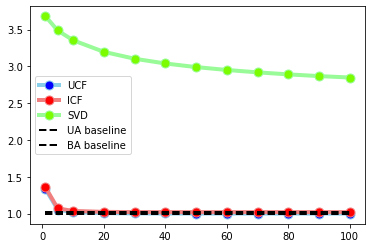

In [16]:
import pandas as pd

UA_RMSE = len(k_values) * [UA_Error]
BA_RMSE = len(k_values) * [BA_Error]

df = pd.DataFrame({'k_values': k_values,  'UCF_RMSE': UCF_RMSE,
                  'ICF_RMSE': ICF_RMSE, 'SVD_RMSE': SVD_RMSE, 'UA_RMSE': UA_RMSE, 'BA_RMSE': BA_RMSE})
 
# multiple line plot
plt.plot( 'k_values', 'UCF_RMSE', data=df, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4, label='UCF')
plt.plot( 'k_values', 'ICF_RMSE', data=df, marker='o', markerfacecolor='red', markersize=9, color='lightcoral', linewidth=4, label='ICF')
plt.plot( 'k_values', 'SVD_RMSE', data=df, marker='o', markerfacecolor='lawngreen', markersize=9, color='palegreen', linewidth=4, label='SVD')
plt.plot( 'k_values', 'UA_RMSE', data=df, marker='', color='black', linewidth=2, linestyle='dashed', label="UA baseline")
plt.plot( 'k_values', 'BA_RMSE', data=df, marker='', color='black', linewidth=2, linestyle='dashed', label="BA baseline")
plt.legend()

Repeating the graph for the zoomed-in values.

In [17]:
zoomed_in_k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

UCF_RMSE_zoomed = []
ICF_RMSE_zoomed = []
SVD_RMSE_zoomed = []

for k in zoomed_in_k_values:
    UCF_RMSE_zoomed.append(calculate_RMSE(removedRatings, UCF(k)))
    ICF_RMSE_zoomed.append(calculate_RMSE(removedRatings, ICF(k)))
    SVD_RMSE_zoomed.append(calculate_RMSE(removedRatings, SVD(k)))
    
UA_RMSE = len(zoomed_in_k_values) * [UA_Error]
BA_RMSE = len(zoomed_in_k_values) * [BA_Error]

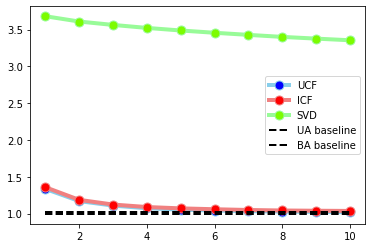

In [18]:
df = pd.DataFrame({'k_values': zoomed_in_k_values,  'UCF_RMSE': UCF_RMSE_zoomed,
                  'ICF_RMSE': ICF_RMSE_zoomed, 'SVD_RMSE': SVD_RMSE_zoomed, 'UA_RMSE': UA_RMSE, 'BA_RMSE': BA_RMSE})
 
# multiple line plot
plt.plot( 'k_values', 'UCF_RMSE', data=df, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4, label='UCF')
plt.plot( 'k_values', 'ICF_RMSE', data=df, marker='o', markerfacecolor='red', markersize=9, color='lightcoral', linewidth=4, label='ICF')
plt.plot( 'k_values', 'SVD_RMSE', data=df, marker='o', markerfacecolor='lawngreen', markersize=9, color='palegreen', linewidth=4, label='SVD')
plt.plot( 'k_values', 'UA_RMSE', data=df, marker='', color='black', linewidth=2, linestyle='dashed', label="UA baseline")
plt.plot( 'k_values', 'BA_RMSE', data=df, marker='', color='black', linewidth=2, linestyle='dashed', label="BA baseline")
plt.legend()